# Prediction of cell types in heart tissue of Mus musculus from single cell RNA sequencing data with two different machine learning models




Laia Torres Masdeu: laia.torresmasdeu@studio.unibo.it


Giacomo Orsini: giacomo.orsini2@studio.unibo.it

Advanced Machine Learning - University of Bologna Master in Bioinformatics - 2023/2024

# Index

*   Introduction
  - Tabula Muris
  - Single cell sequencing
  - Aim of the project
  - References
* Necessary libraries and modules
* Data retrieval
* Data preprocessing
  - Remove unclassified cells
  - Remove genes with 0 expression
  - Remove house keeping genes
  - Data normalization
* Feature selection
  - Variance thresholding
  - Correlation based feature selection
  - Standard scaling
* Dimensionality reduction
  - PCA
  - t-SNE
  - Umap
* Feature encoding
* Random forest
   - Run with default parameters
   - Hyperparameter tuning
* Multilayer perceptron
   - Run with default parameters
   - Hyperparameter tuning
* Conclusion

# Introduction
## Tabula Muris
Tabula Muris is a compendium of single cell transcriptome data from the model organism Mus musculus (mouse), containing nearly 100 000 cells from 20 organs and tissues. The data allow for comparison of gene expression in cell types of different tissues. They also allow for a comparison of two distinct technical approaches: microfluidic droplet-based 3’-end counting and FACS-based full length transcript analysis.

The tabula muris data can be accessed trough the web page: https://tabula-muris.ds.czbiohub.org/

## Single cell sequencing data
Single cell sequencing is a state-of-the-art biotechnology technique that enables the isolation and sequencing of the genetic material from individual cells, with a specific focus on gene expression levels. This allows to identify and characterize distinct cell populations within a complex tissue.

The RNA single cell sequencing data used in this project has been already cleaned and organized into a table format, where rows represent genes and columns correspond to codes associated with individual cells. Each cell in the table indicates the expression level of a specific gene in a particular cell.

Using machine learning methods on this data is crucial for uncovering patterns and relationships; machine learning models can efficiently process high-dimensional data, identify subtle differences and similarities among cells, and classify cell types with high accuracy. This capability is essential for advancing our understanding of cellular functions, uncovering disease mechanisms and identifying potential therapeutic targets.

## Aim of the project
In this project, we have decided to compare the performance of different machine learning methods for cell types recognition in RNA single cell sequencing data. The machine learning models we have used have been Random Forests and Multilayer Perceptrons (MLP).

Regarding the data, we have decided to focus on the heart tissue and the identification of the cells that compose it: fibroblast, endothelial cell, leukocyte, myofibroblast cell, endocardial cell, cardiac muscle cell, smooth muscle cell. Moreover, the data we have used all come from FACS-based full length transcript analysis.

The data after preprocessing has also gone under different dimensionality reduction/visualization methods such as PCA, t-SNE and Umap, for a total of 4 datasets. On this 4 datasets, both the Random Forest and the MLP have been run with a grid search to select the best parameters. The best models from the two machine learning methods will have been compared.

## References

*   Le H, Peng B, Uy J, Carrillo D, Zhang Y, Aevermann BD, et al. (2022) Machine learning for cell type classification from single nucleus RNA sequencing data. PLoS ONE 17(9): e0275070. https://doi.org/10.1371/journal.pone.0275070
*   The Tabula Muris Consortium., Overall coordination., Logistical coordination. et al. Single-cell transcriptomics of 20 mouse organs creates a Tabula Muris. Nature 562, 367–372 (2018). https://doi.org/10.1038/s41586-018-0590-4




# Necessary libraries and modules

These are the different python libraries and modules that have been used throughout the project:

In [1]:
#Basic data processing and visualisation
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

#Feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

#Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap #pip install umap-learn

#Feature encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Random forest modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

#Multilayer perceptron modeling
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner
import tensorflow.keras.backend as K
import random
import tensorflow as tf


# Data retrieval

Data has been retrieved from the Mus Muluscus database (*The Tabula Muris Consortium, 2018*). Specifically, two files have been retrieved:


1.   Metadata table: a file containing information about the single cells, among which the identification code and the cell type annotation (`cell_ontology_class`).
2.   Genes-cells table: a file containing the single cell sequencing data, where column are the cells and rows are genes; in the grid there are the expression levels for each gene in each cell.


In [ ]:
#Switching to bash for simplicity
%%bash

#Download the files
for i in 10700143 13088129;
do
  wget -q https://figshare.com/files/$i

  #Chekpoint
  if [ $? -eq 0 ]; then
    echo "Download of file $i done."
  else
    echo "Failed to download file $i."
    exit 1
  fi
done

#Unzip the file
unzip -q 10700143

#Chekpoint
if [ $? -eq 0 ]; then
  echo "File unzipped."
else
  echo "Failed to unzip file."
fi

#create a directory in which to copy the genes-cells table for the heart tissue
mkdir heart_data
cp FACS/Heart-counts.csv heart_data/heart_counts_raw.csv

#Checkpoint
if [ $? -eq 0 ]; then
  echo "Original file copied."
else
  echo "Failed to copy original file."
fi

#remove original gene-cells table to save space
rm -r FACS
rm 10700143

#Checkpoint
if [ $? -eq 0 ]; then
  echo "Original file removed."
else
  echo "Failed to remove file."
fi

Download of file 10700143 done.
Download of file 13088129 done.
File unzipped.
Original file copied.
Original file removed.


The two files have been transformed to pandas dataframes for easy handling:

In [ ]:
#Transform the metadata file into a pandas dataframe
annotations=pd.read_csv("/content/13088129")

#Select just the cells coming from the Heart tissue
annotations_heart=annotations[annotations["tissue"]=="Heart"].reset_index(drop=True)
annotations_heart.head(5)

<ipython-input-36-228b4d08c396>:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations=pd.read_csv("/content/13088129")


,Neurog3>0_raw,Neurog3>0_scaled,cell,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,plate.barcode,...,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
0,NaN,NaN,A1.B000412.3_56_F.1.1,endothelial cell,CL:0000115,2,NaN,3_56_F,F,B000412,...,NaN,NaN,NaN,NaN,NaN,NaN,RA,Heart,-29.766385,-4.010628
1,NaN,NaN,A1.B000633.3_56_F.1.1,leukocyte,CL:0000738,4,NaN,3_56_F,F,B000633,...,NaN,NaN,NaN,NaN,NaN,NaN,RV,Heart,10.689980,-26.034551
2,NaN,NaN,A1.B000634.3_56_F.1.1,endothelial cell,CL:0000115,6,NaN,3_56_F,F,B000634,...,NaN,NaN,NaN,NaN,NaN,NaN,LA,Heart,-22.531322,-23.512410
3,NaN,NaN,A1.B002423.3_39_F.1.1,fibroblast,CL:0000057,3,NaN,3_39_F,F,B002423,...,NaN,NaN,NaN,NaN,NaN,NaN,RV,Heart,-1.045144,-13.425768
4,NaN,NaN,A1.B002427.3_39_F.1.1,myofibroblast cell,CL:0000186,7,NaN,3_39_F,F,B002427,...,NaN,NaN,NaN,NaN,NaN,NaN,LA,Heart,-8.340210,-41.185128


In [ ]:
#Show all the different heart cell types and the number of examples associated to them
annotations_heart.value_counts("cell_ontology_class")

cell_ontology_class
fibroblast             2119
endothelial cell       1177
leukocyte               523
myofibroblast cell      178
endocardial cell        165
cardiac muscle cell     133
smooth muscle cell       42
Name: count, dtype: int64

In [ ]:
#Transform the genes-cells heart file into a pandas dataframe
heart_count_raw=pd.read_csv("heart_data/heart_counts_raw.csv",index_col="Unnamed: 0")
heart_count_raw

,B12.MAA000398.3_9_M.1.1,D16.MAA000398.3_9_M.1.1,F10.MAA000398.3_9_M.1.1,L17.MAA000398.3_9_M.1.1,N18.MAA000398.3_9_M.1.1,H15.MAA000398.3_9_M.1.1,J14.MAA000398.3_9_M.1.1,B14.MAA000398.3_9_M.1.1,D17.MAA000398.3_9_M.1.1,F14.MAA000398.3_9_M.1.1,...,D5.MAA100097.3_39_F.1.1,A8.MAA100097.3_39_F.1.1,D7.MAA100097.3_39_F.1.1,F2.MAA100097.3_38_F.1.1,F3.MAA100097.3_38_F.1.1,A7.MAA100097.3_39_F.1.1,D6.MAA100097.3_39_F.1.1,F1.MAA100097.3_38_F.1.1,A9.MAA100097.3_39_F.1.1,D8.MAA100097.3_39_F.1.1
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007C21Rik,272,21,54,21,73,105,0,55,141,0,...,0,0,51,0,66,0,147,0,0,100
0610007L01Rik,93,95,43,0,82,71,0,2,71,0,...,0,0,92,0,150,0,116,0,0,0
0610007N19Rik,65,0,0,27,66,0,0,9,11,0,...,0,0,0,0,11,0,0,0,0,31
0610007P08Rik,1,0,0,0,0,34,0,0,0,0,...,0,0,1,0,8,0,0,0,0,2


# Data preprocessing
In the first section of the data preprocessing 4 steps have been perfomed in order to remove data that is either not usable or uninformative for the classification problem:

1.  **Remove unclassified cells**: some cells that are present in the genes-cells file are not annotated in the annotations table, they lack a cell type classification.
2.   **Remove genes which have no expression** in any of the cells: some genes are not expressed in any of the cell of the genes-cells table, they have a 0 value in all the columns, therefore they are not informative nor useful for the classification problem.
3.   **Remove house-keeping genes**: house keeping genes are genes which are expressed in all the cells and cells type; they are therefore not informative and unesufull for the classification
4.   **Data normalisation**: RNA sequencing data often exhibit a wide range of expression values with many low counts and a few high counts. This distribution is typically right-skewed. Log transformation helps normalize these values, making the data more symmetrical and reducing the effect of outliers.

## Remove unclassified cells
To remove unclassified cells, cells that have no metadata associated, the cells from `heart_count_raw` had to be labeled with their respective cell type classification (fibroblast, endothelial cell, leukocyte, myofibroblast cell, endocardial cell, cardiac muscle cell, smooth muscle cell). This information can be found in `annotations_heart`. By joining togheter the metadata and the genes-cells file, the cells that are in the genes cells file but not in the metadata have been automatically dropped. The cell classification types have been added as a column of the dataframe.

The raw `heart_count_raw` dataframe contains **23433 genes and 6002 cells**.

In [ ]:
#Transpose the genes-cells dataframe
heart_count_raw_t = heart_count_raw.T

#In the metadata file, set the cell name as index so to merge the dataframes easily
annotations_heart.set_index('cell', inplace=True)

#Create a df with just the cell tyopes and rename the column cell_ontology_class as cell_classification for semplicity
cell_types_heart = annotations_heart["cell_ontology_class"].rename("cell_classification")

#Join the dataframe togheter: the inner option keeps just the rows that the two dataframes have in common
combined_data = heart_count_raw_t.join(cell_types_heart, how='inner')

display(Markdown(f"There are {heart_count_raw_t.shape[0]-combined_data.shape[0]} cells that have no classification information."))

There are 1637 cells that have no classification information.

Before moving to the next step, cells that are in the metadata table but have no associated cell type (NaN value) also have to be removed from the dataset

In [ ]:
display(Markdown(f"There are {combined_data.isna().sum()[-1]} cells with no defined class."))

#Drop the rows containg a NaN value. The Nan value represent the absence of an annotated cell type
combined_data=combined_data.dropna()

display(combined_data.head(5))

display(Markdown(f"This first step has reduced the raw dataset to **`{combined_data.shape[1]-1}` genes** and **`{combined_data.shape[0]}` cells**."))

There are 28 cells with no defined class.

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene,cell_classification
B12.MAA000398.3_9_M.1.1,0,272,93,65,1,0,0,0,0,0,...,0,0,0,68,1,0,0,17,0,fibroblast
D16.MAA000398.3_9_M.1.1,0,21,95,0,0,0,0,0,0,34,...,0,0,0,389,3,6,0,41,0,endothelial cell
F10.MAA000398.3_9_M.1.1,0,54,43,0,0,0,0,0,0,0,...,41,0,28,45,0,31,0,19,0,myofibroblast cell
L17.MAA000398.3_9_M.1.1,0,21,0,27,0,27,0,0,0,0,...,0,0,0,50,38,0,0,11,0,myofibroblast cell
N18.MAA000398.3_9_M.1.1,0,73,82,66,0,0,58,0,0,68,...,22,0,14,97,99,124,0,39,0,fibroblast


This first step has reduced the raw dataset to **`23433` genes** and **`4337` cells**.

## Remove genes which have no expression in any of the cells
To remove the genes that have no expression across all cells, rows that have 0 value across all columns were exculded.

In [ ]:
#Identify the genes which do not have 0 in all the rows
nonzero_genes = combined_data.loc[:, (combined_data != 0).any()]
display(Markdown(f"There are {combined_data.shape[1]-nonzero_genes.shape[1]} genes that have no expression in any cells."))

display(nonzero_genes.head(5))

display(Markdown(f"The whole step reduced the raw dataset to **`{nonzero_genes.shape[1]-1}` genes** and **`{nonzero_genes.shape[0]}` cells**."))

There are 2382 genes that have no expression in any cells.

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,cell_classification
B12.MAA000398.3_9_M.1.1,0,272,93,65,1,0,0,0,0,0,...,8,0,0,0,68,1,0,0,17,fibroblast
D16.MAA000398.3_9_M.1.1,0,21,95,0,0,0,0,0,0,34,...,0,0,0,0,389,3,6,0,41,endothelial cell
F10.MAA000398.3_9_M.1.1,0,54,43,0,0,0,0,0,0,0,...,0,41,0,28,45,0,31,0,19,myofibroblast cell
L17.MAA000398.3_9_M.1.1,0,21,0,27,0,27,0,0,0,0,...,0,0,0,0,50,38,0,0,11,myofibroblast cell
N18.MAA000398.3_9_M.1.1,0,73,82,66,0,0,58,0,0,68,...,0,22,0,14,97,99,124,0,39,fibroblast


The whole step reduced the raw dataset to **`21051` genes** and **`4337` cells**.

## Removal of house-keeping genes
House-keeping genes are genes whose expression does not vary between cell types; therefore, they are not informative in the ML task that concerns this project, as we are interested in using informative genes to discern between cell types. To be able to determine these genes, the Median Gene Expression within each Cell Type (MGECT) was computed, and genes with zero variance for their MGECT across all cell types were excluded (*Le H, 2022*).

In [ ]:
#Calculate the Median Gene Expression within each Cell Type
mgect_expression = nonzero_genes.groupby('cell_classification').median()
mgect_expression

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell_classification,,,,,,,,,,,,,,,,,,,,,
cardiac muscle cell,0.0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
endocardial cell,0.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,0.0,0.0,0.0
endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fibroblast,0.0,197.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0
leukocyte,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0
myofibroblast cell,0.0,43.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
smooth muscle cell,0.0,10.0,0.0,9.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,369.0,0.0,0.0,0.0,0.0


In [ ]:
#Calculate the variance for each cell type
variance = mgect_expression.var(axis=0)

#Exclude the genes that have 0 variance in all cell types
filtered_genes = variance[variance != 0].index

#Create a new datafarme that contains the genes which do not have 0 variance and the cell classification column
heart_count = nonzero_genes[filtered_genes.tolist() + ['cell_classification']]

display(Markdown(f"There are {nonzero_genes.shape[1]-heart_count.shape[1]} house keeping genes."))
display(heart_count.head(5))

display(Markdown(f"This step reduced the dataset to **`{heart_count.shape[1]-1}` genes** and **`{heart_count.shape[0]}` cells**."))

There are 16725 house keeping genes.

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010K14Rik,0610010O12Rik,0610012G03Rik,0610031J06Rik,...,Zmat5,Zmiz1,Zmynd11,Zmynd8,Znhit1,Zranb2,Zwint,Zyx,l7Rn6,cell_classification
B12.MAA000398.3_9_M.1.1,272,93,65,0,141,0,32,2,2,78,...,0,98,0,11,14,196,0,68,17,fibroblast
D16.MAA000398.3_9_M.1.1,21,95,0,34,0,57,38,0,132,772,...,0,338,25,28,22,0,0,389,41,endothelial cell
F10.MAA000398.3_9_M.1.1,54,43,0,0,37,0,0,145,0,46,...,0,0,132,12,0,11,66,45,19,myofibroblast cell
L17.MAA000398.3_9_M.1.1,21,0,27,0,9,0,0,98,11,62,...,0,4,3,0,10,0,84,50,11,myofibroblast cell
N18.MAA000398.3_9_M.1.1,73,82,66,68,0,0,0,50,0,79,...,0,5,3,0,1,28,0,97,39,fibroblast


This step reduced the dataset to **`4326` genes** and **`4337` cells**.

## Data normalization
**Log transformation** stabilizes the variance and normalizes the distribution of gene expression values. This is important for the nexts steps as feature selection methods (variance thresholding, correlation-based selection, and statistical tests) work better on data that has a normalized distribution. Log transformation before feature selection ensures that the relationships between gene expression levels are consistent and more biologically meaningful.


In [ ]:
#Remove the cell classification column from the dataframe and store it in another dataframe
cell_classification = heart_count[['cell_classification']]
heart_count=heart_count.drop(columns=["cell_classification"])

In [ ]:
#Use numpy to appply log transformation (log1p is log(1 + x))
log_heart_count = np.log1p(heart_count)
display(log_heart_count.head(5))

display(Markdown(f"As expected, this step has not reduced the size of the dataframe (**`{log_heart_count.shape[1]}` genes** and **`{log_heart_count.shape[0]}`** cells)")).

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010K14Rik,0610010O12Rik,0610012G03Rik,0610031J06Rik,...,Zmat2,Zmat5,Zmiz1,Zmynd11,Zmynd8,Znhit1,Zranb2,Zwint,Zyx,l7Rn6
B12.MAA000398.3_9_M.1.1,5.609472,4.543295,4.189655,0.000000,4.955827,0.000000,3.496508,1.098612,1.098612,4.369448,...,3.713572,0.0,4.595120,0.000000,2.484907,2.708050,5.283204,0.000000,4.234107,2.890372
D16.MAA000398.3_9_M.1.1,3.091042,4.564348,0.000000,3.555348,0.000000,4.060443,3.663562,0.000000,4.890349,6.650279,...,4.290459,0.0,5.826000,3.258097,3.367296,3.135494,0.000000,0.000000,5.966147,3.737670
F10.MAA000398.3_9_M.1.1,4.007333,3.784190,0.000000,0.000000,3.637586,0.000000,0.000000,4.983607,0.000000,3.850148,...,4.262680,0.0,0.000000,4.890349,2.564949,0.000000,2.484907,4.204693,3.828641,2.995732
L17.MAA000398.3_9_M.1.1,3.091042,0.000000,3.332205,0.000000,2.302585,0.000000,0.000000,4.595120,2.484907,4.143135,...,3.218876,0.0,1.609438,1.386294,0.000000,2.397895,0.000000,4.442651,3.931826,2.484907
N18.MAA000398.3_9_M.1.1,4.304065,4.418841,4.204693,4.234107,0.000000,0.000000,0.000000,3.931826,0.000000,4.382027,...,1.386294,0.0,1.791759,1.386294,0.000000,0.693147,3.367296,0.000000,4.584967,3.688879


As expected, this step has not reduced the size of the dataframe (**`4326` genes** and **`4337`** cells)

# Feature selection
After preprocessing, data would be ready to use, but in order to increase the efficency of our methods and reduce the complexity of the task we decided to be more selective on our features. Feature selection is an important aspect of preparing data for machine learning, as it reduces the dimensionality of the data, improve model performance, and enhance interpretability by selecting the most informative features and eliminate eventual noise. The steps performed here have been:

1.   **Variance tresholding**: remove genes with very low variance across all cells type; similarly to removing genes with 0 variance, this step will remove genes not very usefull to discern between cell types.
2.   **Correlation based feature selection**: remove redundant and higly correlated genes.
3.  **Standard scaling**: standard scaling ensures that each gene contributes equally to the analysis by having zero mean and unit variance.





## Variance tresholding
Remove features with low variance. Similar to excluding zero-variance genes, you can remove genes with very low variance across samples, as they may not be informative.



In [ ]:
#Set the threshold to 2.5 as done in the paper
threshold = 2.5

#Initialize the variance threshold selector
selector = VarianceThreshold(threshold)

#Apply the selector to the normalized data
variance_selected_data = selector.fit_transform(log_heart_count)

#Convert the result back to a DataFrame, maintaining the original index
variance_selected_df = pd.DataFrame(variance_selected_data, index=log_heart_count.index)

display(Markdown(f"There are {log_heart_count.shape[1]-variance_selected_df.shape[1]} genes that have no expression in any cells."))
display(Markdown(f"Therefore, this step reduced the dataset to **`{variance_selected_df.shape[1]}` genes** and **`{variance_selected_df.shape[0]}` cells**."))

There are 820 genes that have no expression in any cells.

Therefore, this step reduced the dataset to **`3506` genes** and **`4337` cells**.

## Correlation-Based Feature Selection
Remove highly correlated genes (features), as they provide redundant information. Select one gene from each set of highly correlated genes.


In [ ]:
#Calculate correlation matrix
corr_matrix = variance_selected_df.corr().abs()

#Select the upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#Find index of features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

#Drop the genes
correlation_selected_df = variance_selected_df.drop(columns=to_drop)

display(Markdown(f"There are {variance_selected_df.shape[1]-correlation_selected_df.shape[1]} genes that have no expression in any cells."))
display(Markdown(f"Therefore, this step reduced the dataset to **`{correlation_selected_df.shape[1]}` genes** and **`{correlation_selected_df.shape[0]}` cells**."))

There are 33 genes that have no expression in any cells.

Therefore, this step reduced the dataset to **`3473` genes** and **`4337` cells**.

## Standard Scaling
Standard scaling ensures that each gene contributes equally to the analysis by having zero mean and unit variance. It is essential to apply dimensionality reduction tecnhiques such as PCA.



In [ ]:
#Initialize the scaler
scaler=StandardScaler()

#Apply standard scaling
scaled_data=scaler.fit_transform(correlation_selected_df)

#Convert the scaled data back to a DataFrame
scaled_df=pd.DataFrame(scaled_data,index=correlation_selected_df.index)
scaled_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472
B12.MAA000398.3_9_M.1.1,0.855036,1.601745,1.317983,-0.470548,1.321129,-0.469924,0.869153,-0.050479,-0.263019,0.530397,...,0.985102,-0.59371,1.537594,-0.725635,0.639321,0.898374,2.018219,-0.580537,0.496955,0.696304
D16.MAA000398.3_9_M.1.1,-0.062353,1.611895,-0.715256,1.529545,-0.837302,1.922271,0.945775,-0.574588,1.398314,1.338248,...,1.266193,-0.59371,2.133236,0.743759,1.095229,1.145623,-0.669794,-0.580537,1.157579,1.082193
F10.MAA000398.3_9_M.1.1,0.271425,1.235803,-0.715256,-0.470548,0.746991,-0.469924,-0.734575,1.802913,-0.744372,0.346465,...,1.252657,-0.59371,-0.686055,1.479901,0.680677,-0.668059,0.594488,1.322842,0.342305,0.744289
L17.MAA000398.3_9_M.1.1,-0.062353,-0.588446,0.901862,-0.470548,0.165552,-0.469924,-0.734575,1.617580,0.344380,0.450238,...,0.744059,-0.59371,0.092777,-0.100419,-0.644565,0.718969,-0.669794,1.430561,0.381661,0.511641
N18.MAA000398.3_9_M.1.1,0.379515,1.541750,1.325280,1.911386,-0.837302,-0.469924,-0.734575,1.301146,-0.744372,0.534852,...,-0.148874,-0.59371,0.181005,-0.100419,-0.644565,-0.267118,1.043435,-0.580537,0.630778,1.059972


In [ ]:
#Create a final df that has the cell classification as last column
final_df=scaled_df.copy()
final_df['cell_classification'] = cell_classification

display(final_df.head(5))
display(Markdown(f"The final dataset is composed by **`{final_df.shape[1]-1}` genes** across **`{final_df.shape[0]}` cells**, as well as one column (`cell_classification`) that contains the information on the cell class."))

,0,1,2,3,4,5,6,7,8,9,...,3464,3465,3466,3467,3468,3469,3470,3471,3472,cell_classification
B12.MAA000398.3_9_M.1.1,0.855036,1.601745,1.317983,-0.470548,1.321129,-0.469924,0.869153,-0.050479,-0.263019,0.530397,...,-0.59371,1.537594,-0.725635,0.639321,0.898374,2.018219,-0.580537,0.496955,0.696304,fibroblast
D16.MAA000398.3_9_M.1.1,-0.062353,1.611895,-0.715256,1.529545,-0.837302,1.922271,0.945775,-0.574588,1.398314,1.338248,...,-0.59371,2.133236,0.743759,1.095229,1.145623,-0.669794,-0.580537,1.157579,1.082193,endothelial cell
F10.MAA000398.3_9_M.1.1,0.271425,1.235803,-0.715256,-0.470548,0.746991,-0.469924,-0.734575,1.802913,-0.744372,0.346465,...,-0.59371,-0.686055,1.479901,0.680677,-0.668059,0.594488,1.322842,0.342305,0.744289,myofibroblast cell
L17.MAA000398.3_9_M.1.1,-0.062353,-0.588446,0.901862,-0.470548,0.165552,-0.469924,-0.734575,1.617580,0.344380,0.450238,...,-0.59371,0.092777,-0.100419,-0.644565,0.718969,-0.669794,1.430561,0.381661,0.511641,myofibroblast cell
N18.MAA000398.3_9_M.1.1,0.379515,1.541750,1.325280,1.911386,-0.837302,-0.469924,-0.734575,1.301146,-0.744372,0.534852,...,-0.59371,0.181005,-0.100419,-0.644565,-0.267118,1.043435,-0.580537,0.630778,1.059972,fibroblast


The final dataset is composed by **`3473` genes** across **`4337` cells**, as well as one column (`cell_classification`) that contains the information on the cell class.

# Dimensionality reduction

Dimensionality reduction is a significant step in machine learning, especially when dealing with high-dimensional datasets such as single cell sequencing data. It aims to reduce the number of features while retaining the essential information and structure of the data. This simplification facilitates visualization, reduces computational complexity, and can improve the performance of machine learning models by eliminating noise and redundant features. There are three main dimensionality reduction techniques:

1. **Principal Component Analysis (PCA)**: is a widely used method that transforms the data into a set of orthogonal components, capturing the maximum variance with the fewest number of components.
2.  **t-Distributed Stochastic Neighbor Embedding (t-SNE)**: is a powerful technique, particularly for visualization, as it emphasizes the local structure and maintains the high-dimensional pairwise distances in lower dimensions.
3.  **Uniform Manifold Approximation and Projection (UMAP)**: is a newer method that balances the preservation of local and global data structure, providing more interpretable and faster results than t-SNE.

Each of these techniques serves to uncover the underlying patterns and relationships in complex datasets, making them indispensable tools in the analysis and interpretation of high-dimensional data like single cell sequencing.

In the project, we have created 4 datasets, one without any dimensionality reduction, the other threes each with a different technique.

## PCA
PCA is a linear dimensionality reduction technique that projects data onto the principal components, which are directions of maximum variance. It is used to reduce the dimensionality of the data while preserving as much variability as possible. It is based on covariance matrix, eigenvalues and eigenvector.

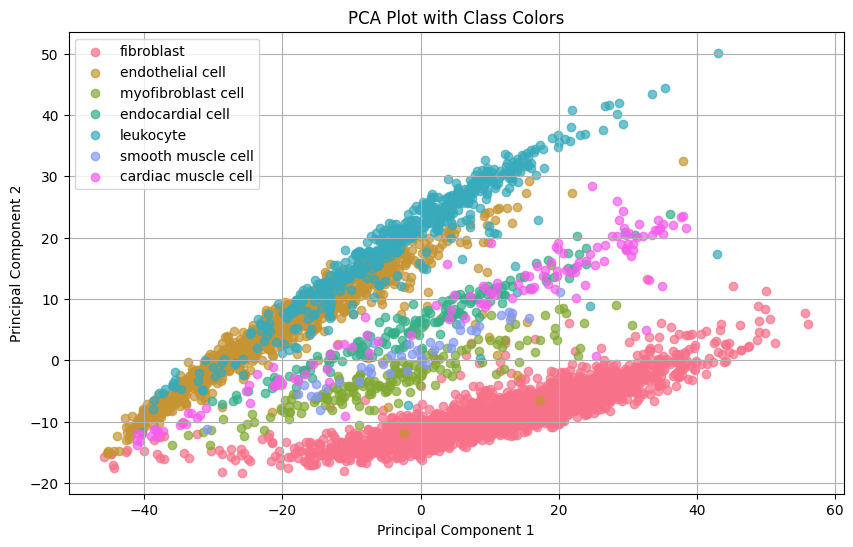

In [ ]:
#Apply PCA. random state=42 assures that at each iteration the random state is the same
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(scaled_df)
pca_result_df = pd.DataFrame(pca_result, columns=['Component 1', 'Component 2'], index=scaled_df.index)

#Define cells labels for the plot legend
class_labels = final_df['cell_classification']

#Define colors for each label
class_colors = sns.color_palette("husl", len(class_labels.unique()))

#Plot PCA results with colors
plt.figure(figsize=(10, 6))
for i, label in enumerate(class_labels.unique()):
    plt.scatter(pca_result_df[class_labels == label]['Component 1'], pca_result_df[class_labels == label]['Component 2'],
                label=label, color=class_colors[i], alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot with Class Colors')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Store the final PCA dataframe with its corresponding cell class
final_df_pca=pca_result_df.copy()
final_df_pca['cell_classification'] = cell_classification

display(final_df_pca.head(5))
display(Markdown(f"This dataframe has size `{final_df_pca.shape}` (composed by **`{final_df_pca.shape[1]-1}` components** across **`{final_df_pca.shape[0]}` cells**, as well as one column (`cell_classification`) that contains the information on the cell class."))

,Component 1,Component 2,cell_classification
B12.MAA000398.3_9_M.1.1,34.697090,0.280257,fibroblast
D16.MAA000398.3_9_M.1.1,9.407001,24.066797,endothelial cell
F10.MAA000398.3_9_M.1.1,12.820769,5.497777,myofibroblast cell
L17.MAA000398.3_9_M.1.1,10.037056,3.280025,myofibroblast cell
N18.MAA000398.3_9_M.1.1,16.664149,-7.078687,fibroblast


This dataframe has size `(4337, 3)` (composed by **`2` components** across **`4337` cells**, as well as one column (`cell_classification`) that contains the information on the cell class.

## t-SNE
t-SNE is a non-linear dimensionality reduction technique that is particularly good at preserving local structures in data, making it useful for visualizing clusters. It works by minimizing the divergence between two distributions: one representing pairwise similarities in the high-dimensional space and one in the low-dimensional space.


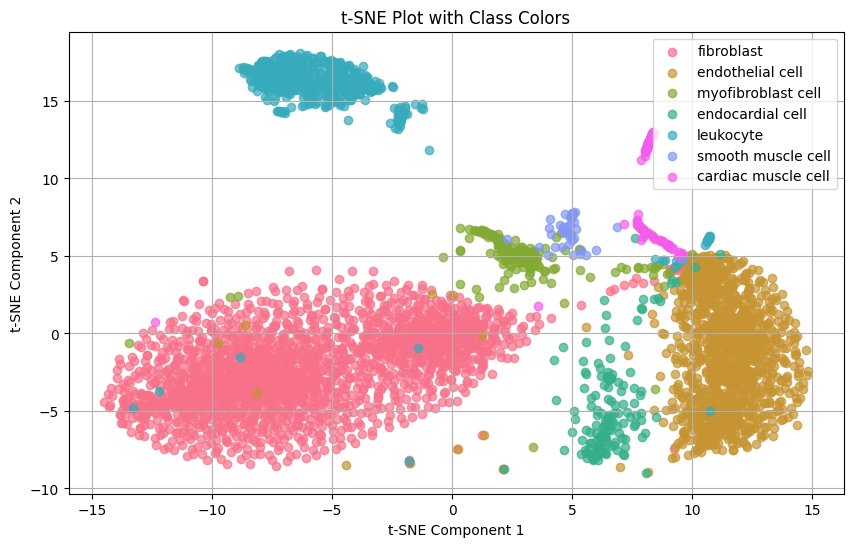

In [ ]:
#Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_df)
tsne_result_df = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'], index=scaled_df.index)

#Define cells labels for the plot legend
class_labels = final_df['cell_classification']

#Define colors for each label
class_colors = sns.color_palette("husl", len(class_labels.unique()))

#Plot t-SNE results
plt.figure(figsize=(10, 6))
class_colors = sns.color_palette("husl", len(class_labels.unique()))
for i, label in enumerate(class_labels.unique()):
    plt.scatter(tsne_result_df[class_labels == label]['Component 1'], tsne_result_df[class_labels == label]['Component 2'],
                label=label, color=class_colors[i], alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Plot with Class Colors')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Store the final t-SNE dataframe with its corresponding cell class
final_df_tsne=tsne_result_df.copy()
final_df_tsne['cell_classification'] = cell_classification

display(final_df_tsne.head(5))
display(Markdown(f"This dataframe has size `{final_df_tsne.shape}` (composed by **`{final_df_tsne.shape[1]-1}` components** across **`{final_df_tsne.shape[0]}` cells**, as well as one column (`cell_classification`) that contains the information on the cell class."))

,Component 1,Component 2,cell_classification
B12.MAA000398.3_9_M.1.1,-12.588661,-4.662022,fibroblast
D16.MAA000398.3_9_M.1.1,10.275681,-7.401987,endothelial cell
F10.MAA000398.3_9_M.1.1,1.461666,6.423032,myofibroblast cell
L17.MAA000398.3_9_M.1.1,1.670328,6.260969,myofibroblast cell
N18.MAA000398.3_9_M.1.1,-8.692788,-3.116713,fibroblast


This dataframe has size `(4337, 3)` (composed by **`2` components** across **`4337` cells**, as well as one column (`cell_classification`) that contains the information on the cell class.

In [ ]:
final_df.to_csv("final_df.csv")
final_df_pca.to_csv("final_df_pca.csv")
final_df_tsne.to_csv("final_df_tsne.csv")

## UMAP
UMAP is a non-linear dimensionality reduction technique that is particularly good at preserving the global structure of the data while maintaining local relationships. It’s based on manifold learning and is useful for visualizing complex, high-dimensional data.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


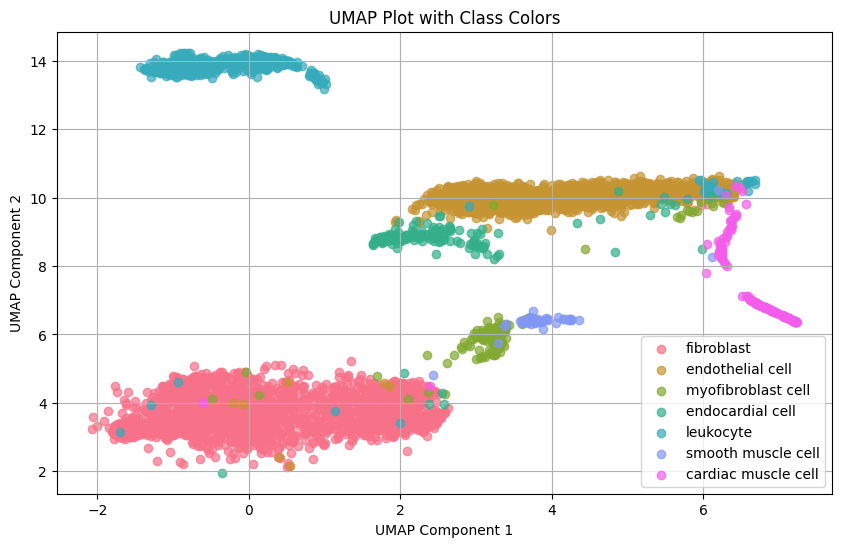

In [ ]:
#Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(scaled_df)
umap_result_df = pd.DataFrame(umap_result, columns=['Component 1', 'Component 2'], index=scaled_df.index)

#Define cells labels for the plot legend
class_labels = final_df['cell_classification']

#Define colors for each label
class_colors = sns.color_palette("husl", len(class_labels.unique()))

#Plot UMAP results
plt.figure(figsize=(10, 6))
for i, label in enumerate(class_labels.unique()):
    plt.scatter(umap_result_df[class_labels == label]['Component 1'], umap_result_df[class_labels == label]['Component 2'],
                label=label, color=class_colors[i], alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Plot with Class Colors')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
##Store the final UMAP dataframe with its corresponding cell class
final_df_umap=umap_result_df.copy()
final_df_umap['cell_classification'] = cell_classification

display(final_df_umap.head(5))
display(Markdown(f"This dataframe has size `{final_df_umap.shape}` (composed by **`{final_df_umap.shape[1]-1}` components** across **`{final_df_umap.shape[0]}` cells**, as well as one column (`cell_classification`) that contains the information on the cell class."))

,Component 1,Component 2,cell_classification
B12.MAA000398.3_9_M.1.1,-1.648715,3.253406,fibroblast
D16.MAA000398.3_9_M.1.1,2.504149,9.822792,endothelial cell
F10.MAA000398.3_9_M.1.1,3.240356,5.489417,myofibroblast cell
L17.MAA000398.3_9_M.1.1,3.259627,5.570333,myofibroblast cell
N18.MAA000398.3_9_M.1.1,-0.694635,3.920166,fibroblast


This dataframe has size `(4337, 3)` (composed by **`2` components** across **`4337` cells**, as well as one column (`cell_classification`) that contains the information on the cell class.

These 4 datasets (`final_df`, `final_df_pca`, `final_df_tsne`, `final_df_umap`) will be used to test both the two machine learning models. As it can be seen from the plots, the classes in the datsets are not well balanced, as some of them have very few examples; nontheless, it would be a biological artifact to remove them. For these classes (in particoul smooth muscle cells), a worse result in the classifcation is expected because of the lack of examples.

In [ ]:
#Count entries for each class
final_df.value_counts("cell_ontology_class")

# Feature encoding and dataset splitting
Feature encoding is the process of converting categorical data or other types of non-numeric data into a numerical format. The cell types labels have to be transfomerd in order to be used by the model.

The datasets have to be split in training and testing set with a proportion of 80 and 20. The models will be trained on the training data, which have to be representative of the whole dataset; after training, the model will be tested on the testing set in which cells do not have a label.

K-fold Cross-validation, a procedure that helps ensure that the model's performance is consistent and not dependent on a particular split of the data, has also been performed: the training set has been divided into smaller subsets, at every iteration one of the split will be used to test the model.

In [ ]:
def encoding_and_splitting(df, df_type):
  #Split the df into features (X) and class (y)
  X = df.drop(columns=['cell_classification'])
  y_raw = df['cell_classification']

  #Encode class labels (to numeric values)
  le = LabelEncoder()
  y = le.fit_transform(y_raw)

  #Split the data into training (80%) and testing (20%) sets, ensuring that the distribution of each class (y) is approximately the same in both sets ("stratify"), and with "random_state" to ensure reproducibility
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  #Save each subset to a CSV file with appropriate names
  subsets = {
      'X_train': X_train,
      'X_test': X_test,
      'y_train': pd.DataFrame(y_train, columns=['cell_classification']),
      'y_test': pd.DataFrame(y_test, columns=['cell_classification'])
  }

  for subset_name, subset_df in subsets.items():
    subset_df.to_csv(f"datasets/heart_count{df_type}_{subset_name}.csv", index=False)

  return X_train, X_test, y_train, y_test

In [ ]:
#Build training and test sets for each of the datasets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = encoding_and_splitting(final_df, "_orig")
X_train_pca, X_test_pca, y_train_pca, y_test_pca = encoding_and_splitting(final_df_pca, "_pca")
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = encoding_and_splitting(final_df_tsne, "_tsne")
X_train_umap, X_test_umap, y_train_umap, y_test_umap = encoding_and_splitting(final_df_umap, "_umap")

# Random Forest
Random forests are a powerful and versatile ensemble method used for both classification and regression tasks. Ensemble learning methods are made up of a set of classifiers and their predictions are aggregated to identify the most popular result. Random forests combine the output of multiple decision trees to reach a single result. By averaging the predictions of multiple trees, random forests reduce variance and improve generalization to unseen data. They are known for their high accuracy, ease of use, and ability to handle large datasets with many features.

## Run with Default Parameters
We first decided to make a multiclass random forest prediction on our RNA-seq data using the default parameters, to have a baseline assesment for each dataset (`no dimensionality reduction (original)`,`PCA`,`t-SNE` and `UMAP`).

To do so, we computed 3 functions to fit (`rf_model_fit`), predict (`rf_model_predict`) and evaluate (`model_evaluate`) each model, which were englobed in one general function (`rf_model_default`):

In [199]:
def rf_model_default(X_train, X_test, y_train, y_test, dataset_name):
  ''' Function that evaluates a RandomForest multi-class problem
  using the default parameters (to evaluate if the model works)'''
  
  #Name the dataset
  display(Markdown(f"### Evaluating {dataset_name} model"))

  #Fit the model
  model, model_parameters = rf_model_fit(X_train, y_train)

  display(Markdown("The parameters for this model are:"))
  print("\t", end="")
  for i, (param, value) in enumerate(model_parameters.items()):
      if i > 0:
          print(", ", end="")
      print(f"{param}: {value}", end="")
  
  #Evaluate the model with the test set
  accuracy, class_report, conf_matrix = rf_model_predict(model, X_test, y_test)

  return dataset_name, accuracy, class_report, conf_matrix

def rf_model_fit(X_train, y_train):
  '''Function that initializes and trains the random forest classifier with default parameters.'''
  #Initialize the model (just considering random_state=42)
  model = RandomForestClassifier(random_state=42)

  #Train the model
  model.fit(X_train, y_train)

  return model, model.get_params()

def rf_model_predict(model, X_test, y_test):
  '''Function that predicts and evaluates a given model, by computing its accuracy.'''

  #Predict the labels for the test set
  y_pred = model.predict(X_test)

  #Calculate the model's accuracy, classification report and confusion matrix
  accuracy = accuracy_score(y_test, y_pred)
  class_report = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  return accuracy, class_report, conf_matrix

To evaluate the model, and to visualise it more clearly, we wrote the following function:

In [5]:
def result_plotting(results, model_name, param_type):
    '''Function that takes the results of 4 dataset runs and prints the confusion matrix, classification report and accuracy values.'''
    
    #Define the cell classes (in alphabetical/encoding order)
    cell_class = ['cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell', 'smooth muscle cell']

    # Create a grid for the subplots (3x2 for better visualisation purposes)
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))

    #make a sub-figure for each of the datasets
    for ax, result in zip(axes.flatten(), results):
        dataset_name, accuracy, class_report, conf_matrix = result

        #Plot the confusion matrix
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax, square=True)  # Ensure square=True
        ax.set_title(f"{dataset_name} model", fontsize=12)
        ax.set_xlabel('Predicted labels\n\n\n\n', fontsize=10)
        ax.set_ylabel('True labels', fontsize=10)

        ax.set_xticklabels(cell_class, fontsize=9, rotation=45, ha="right")
        ax.set_yticklabels(cell_class, fontsize=9, rotation=0)

        accuracy_text = f"Accuracy: {accuracy}"
        class_report_text = f"\n\n\n{class_report}"

        #Print the accuracy score
        ax.text(1.05, 0.9, accuracy_text,
                verticalalignment='center', horizontalalignment='left',
                transform=ax.transAxes, fontsize=11, color="black", weight='bold')

        #Print the classification report
        ax.text(1.05, 0.5, class_report_text,
                verticalalignment='center', horizontalalignment='left',
                transform=ax.transAxes, fontsize=11, bbox=dict(facecolor='white', alpha=0.2))

    #Remove any empty subplots (as it is a 3x2 grid, it is plotting 6 figures, 2 of which are empty)
    for i in range(len(results),6):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.suptitle(f"Confusion matrix, accuracy and classification report for {model_name} model with {param_type}", fontsize=16, y=1.05)
    plt.show()

With the classification report:

In [200]:
rf_default_results = []
rf_default_results.append(rf_model_default(X_train_orig, X_test_orig, y_train_orig, y_test_orig, "Original"))
rf_default_results.append(rf_model_default(X_train_pca, X_test_pca, y_train_pca, y_test_pca, "PCA"))
rf_default_results.append(rf_model_default(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne, "t-SNE"))
rf_default_results.append(rf_model_default(X_train_umap, X_test_umap, y_train_umap, y_test_umap, "UMAP"))

### Evaluating Original model

The parameters for this model are:

	bootstrap: True, ccp_alpha: 0.0, class_weight: None, criterion: gini, max_depth: None, max_features: sqrt, max_leaf_nodes: None, max_samples: None, min_impurity_decrease: 0.0, min_samples_leaf: 1, min_samples_split: 2, min_weight_fraction_leaf: 0.0, monotonic_cst: None, n_estimators: 100, n_jobs: None, oob_score: False, random_state: 42, verbose: 0, warm_start: False

### Evaluating PCA model

The parameters for this model are:

	bootstrap: True, ccp_alpha: 0.0, class_weight: None, criterion: gini, max_depth: None, max_features: sqrt, max_leaf_nodes: None, max_samples: None, min_impurity_decrease: 0.0, min_samples_leaf: 1, min_samples_split: 2, min_weight_fraction_leaf: 0.0, monotonic_cst: None, n_estimators: 100, n_jobs: None, oob_score: False, random_state: 42, verbose: 0, warm_start: False

### Evaluating t-SNE model

The parameters for this model are:

	bootstrap: True, ccp_alpha: 0.0, class_weight: None, criterion: gini, max_depth: None, max_features: sqrt, max_leaf_nodes: None, max_samples: None, min_impurity_decrease: 0.0, min_samples_leaf: 1, min_samples_split: 2, min_weight_fraction_leaf: 0.0, monotonic_cst: None, n_estimators: 100, n_jobs: None, oob_score: False, random_state: 42, verbose: 0, warm_start: False

### Evaluating UMAP model

The parameters for this model are:

	bootstrap: True, ccp_alpha: 0.0, class_weight: None, criterion: gini, max_depth: None, max_features: sqrt, max_leaf_nodes: None, max_samples: None, min_impurity_decrease: 0.0, min_samples_leaf: 1, min_samples_split: 2, min_weight_fraction_leaf: 0.0, monotonic_cst: None, n_estimators: 100, n_jobs: None, oob_score: False, random_state: 42, verbose: 0, warm_start: False

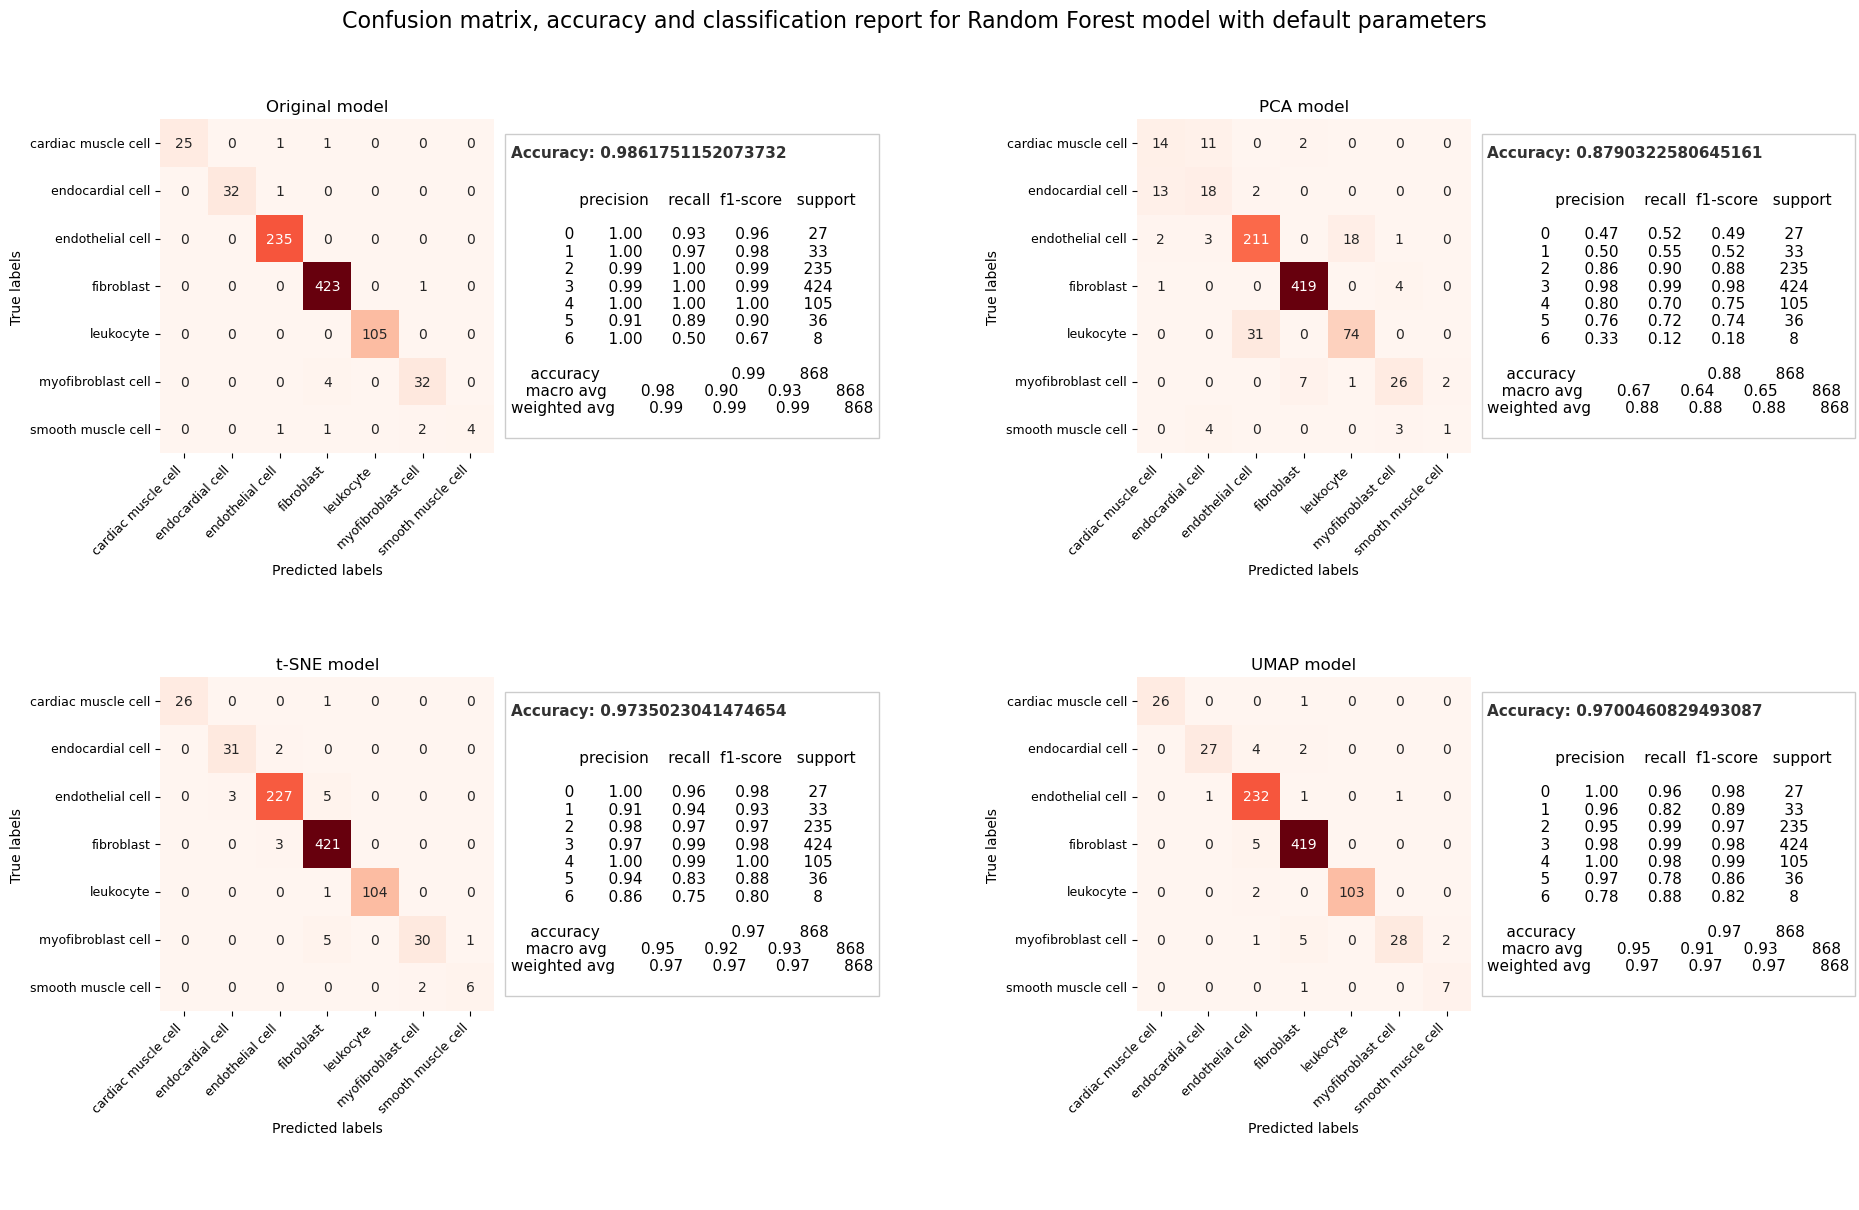

In [201]:
result_plotting(rf_default_results, "Random Forest", "default parameters")

The classification reports indicate that the model obtained by training on the original (no dimensionality reduction) data achieve better results with an accuracy of **0.986**. The model obtained from the PCA dataset was the one that performed the worst with an accuracy of **0.879**. The overall decrease in the performance in the datasets that went trough dimensionality reduction could be explained by the loss of signifcant features; as much as these tecnhiques aim to retain the essential information and structure of the data, there is a loss of information that could leed to worse classification of some cell types, such as in this case.

## Hyperparameter tuning
Can we improve the models? Yes. Machine learning models come with a set of tunable parameters that can greatly change the outcome of the analysis. We decided to fine-tune the model by performing a Grid Search with Cross-Validation.

To do so, we computed a new fit function (`rf_model_fit_grid`), which computed multiple models taking into consideration the following hyperparameters:
*   **n_estimators**: number of decision trees in the random forest. Increasing `n_estimators` generally improves the performance of the model until a certain point, where additional trees may not significantly improve accuracy but o increase computational cost. Typical values to evaluate are 100, 500, 1000, 1500, exploring a range from a relatively small forest to larger forests, which helps in finding the optimal balance between accuracy and computational efficiency
*   **max_features**: determines the maximum number of features to consider when looking for the best split at each node. By restring or not the number of features, the right max_features can prevent overfitting and improve the diversity among the trees in the forest.
The options we chose to evaluate are 'sqrt' (square root of the number of features), 'log2' (log base 2 of the number of features), and None (consider all features).
*   **bootstrap**: indicates whether bootstrap samples are used when building trees. Bootstrap sampling introduces randomness and diversity in each tree, which can improve the overall performance of the forest. If False, the whole dataset is used to build each tree.

Once all models were computed, the best one was saved and used on the test set, using the same predict function as in the first step (`rf_model_predict`). In this case, the general function (`rf_model_hp_tuning`) is the following:

In [209]:
def rf_model_hp_tuning(X_train, X_test, y_train, y_test, dataset_name):
  ''' Function that finds the best hyperparameters for a RandomForest multi-class
  problem using grid search and cross-validation and evaluates the model's accuracy'''

  #Name the model
  display(Markdown(f"### Evaluating {dataset_name} model"))

  #Fit the model with default parameters (just considering random_state=42)
  model, model_parameters = rf_model_fit_grid(X_train, y_train)

  #Print the parameters for the best-scoring model obtained through CV
  display(Markdown("The hyperparameters for the best scoring model are:"))
  print("\t", end="")
  for i, (param, value) in enumerate(model_parameters.items()):
      if i > 0:
          print(", ", end="")
      print(f"{param}: {value}", end="")

  #Evaluate the model with the test set
  accuracy, class_report, conf_matrix = rf_model_predict(model, X_test, y_test)

  return dataset_name, accuracy, class_report, conf_matrix

  

def rf_model_fit_grid(X_train, y_train):
  '''Function that initializes and trains multiple random forest classifiers by computing
  all possible hyperparameter grid combinations. It returns the best model.'''
  #Initialize the model
  model = RandomForestClassifier(random_state=42, n_estimators=100)

  #Define the parameter grid with the hyperparameters to be tuned
  param_grid = {
      'n_estimators': [100, 500, 1000, 1200],
      'max_features': ['sqrt', 'log2', None],
      'bootstrap': [True, False]
  }

  #Initialize the grid search
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

  #Fit the grid search to the data
  grid_search.fit(X_train, y_train)

  #Best CV accuracy score
  best_score = grid_search.best_score_
  print(f"Best cross-validation accuracy score: {best_score}")

  #CV accuracy score for each parameter combination
  mean_scores = grid_search.cv_results_['mean_test_score']
  params = grid_search.cv_results_['params']

  for mean_score, param in zip(mean_scores, params):
      print(f"Mean accuracy score (CV={grid_search.cv}): {mean_score} with parameters: {param}")


  return grid_search.best_estimator_, grid_search.best_params_

In [210]:
rf_hp_tuning_results = []
rf_hp_tuning_results.append(rf_model_hp_tuning(X_train_orig, X_test_orig, y_train_orig, y_test_orig, "original"))
rf_hp_tuning_results.append(rf_model_hp_tuning(X_train_pca, X_test_pca, y_train_pca, y_test_pca, "PCA"))
rf_hp_tuning_results.append(rf_model_hp_tuning(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne, "t-SNE"))
rf_hp_tuning_results.append(rf_model_hp_tuning(X_train_umap, X_test_umap, y_train_umap, y_test_umap, "UMAP"))

### Evaluating original model

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best cross-validation accuracy score: 0.9864507570559443
Mean accuracy score (CV=5): 0.9847212345771423 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}
Mean accuracy score (CV=5): 0.9844334659896619 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 500}
Mean accuracy score (CV=5): 0.9844334659896619 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1000}
Mean accuracy score (CV=5): 0.9850098348657428 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1200}
Mean accuracy score (CV=5): 0.9668488092119217 with parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}
Mean accuracy score (CV=5): 0.9691538688656844 with parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 500}
Mean accuracy score (CV=5): 0.9685774999896039 with parameters: {'bootstrap': True, 'max_features': 'log2

The hyperparameters for the best scoring model are:

	bootstrap: False, max_features: sqrt, n_estimators: 1000

### Evaluating PCA model

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best cross-validation accuracy score: 0.9008383547288445
Mean accuracy score (CV=5): 0.8988210636625622 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}
Mean accuracy score (CV=5): 0.8999738014147235 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 500}
Mean accuracy score (CV=5): 0.9008383547288445 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1000}
Mean accuracy score (CV=5): 0.9005501702908043 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1200}
Mean accuracy score (CV=5): 0.8988210636625622 with parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}
Mean accuracy score (CV=5): 0.8999738014147235 with parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 500}
Mean accuracy score (CV=5): 0.9008383547288445 with parameters: {'bootstrap': True, 'max_features': 'log2

The hyperparameters for the best scoring model are:

	bootstrap: True, max_features: sqrt, n_estimators: 1000

### Evaluating t-SNE model

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best cross-validation accuracy score: 0.9772267757858536
Mean accuracy score (CV=5): 0.9772263599352936 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}
Mean accuracy score (CV=5): 0.9772263599352936 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 500}
Mean accuracy score (CV=5): 0.9772267757858536 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1000}
Mean accuracy score (CV=5): 0.9772267757858536 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1200}
Mean accuracy score (CV=5): 0.9772263599352936 with parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}
Mean accuracy score (CV=5): 0.9772263599352936 with parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 500}
Mean accuracy score (CV=5): 0.9772267757858536 with parameters: {'bootstrap': True, 'max_features': 'log2

The hyperparameters for the best scoring model are:

	bootstrap: True, max_features: sqrt, n_estimators: 1000

### Evaluating UMAP model

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best cross-validation accuracy score: 0.9633897642543175
Mean accuracy score (CV=5): 0.9628133953782368 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}
Mean accuracy score (CV=5): 0.9628133953782368 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 500}
Mean accuracy score (CV=5): 0.9633897642543175 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1000}
Mean accuracy score (CV=5): 0.9633897642543175 with parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1200}
Mean accuracy score (CV=5): 0.9628133953782368 with parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}
Mean accuracy score (CV=5): 0.9628133953782368 with parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 500}
Mean accuracy score (CV=5): 0.9633897642543175 with parameters: {'bootstrap': True, 'max_features': 'log2

The hyperparameters for the best scoring model are:

	bootstrap: True, max_features: sqrt, n_estimators: 1000

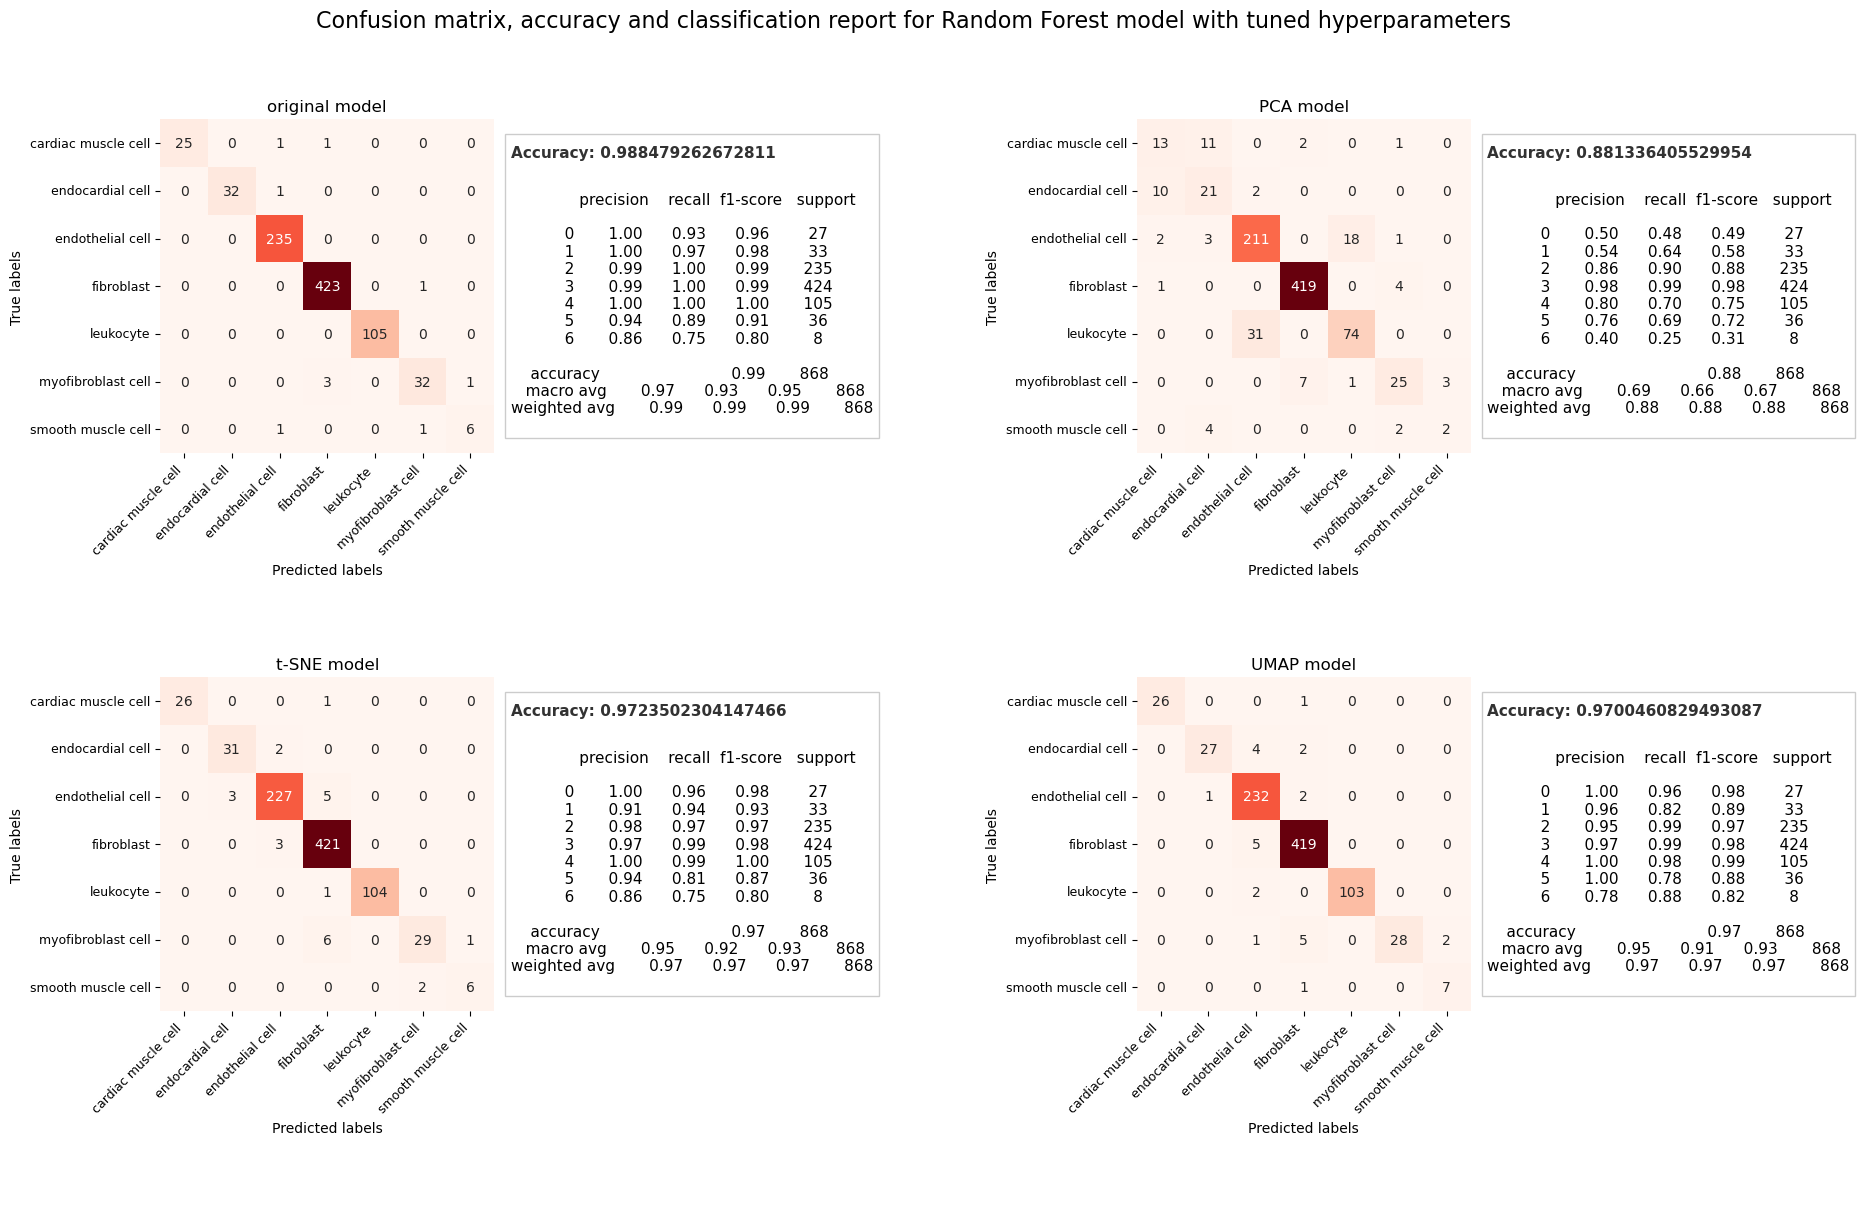

In [ ]:
result_plotting(rf_hp_tuning_results, "Random Forest", "tuned hyperparameters")

The classification reports indicate again that the best model is the one obtained by training on the original data (no dimensionality reduction), with an accuracy of **0.988**. The model obtained from the PCA dataset was still the one that performed the worst with an accuracy **of 0.881**.

Regarding the parameters, the grid search has identified as best parameters:
- n_estimators: 1000
- max_features: sqrt
- Bootstrap: False (True in PCA, t-SNE and UMAP).

The number of decision trees results in a relatively large random forest, while the '`sqrt`' (square root of the number of features) restricts the number of features looked at the split of each node. The absence of Bootstrap indicates that the whole dataset is used.

Also here, the decrease in the performance in the datasets that went trough dimensionality reduction could be explained by the loss of signifcant features; overall, it seems that applying a dimensionality reduction techinque on this kind of dataset, a small, feature rich single cell sequencing dataset, could lower the performances when using a Random Forest classifier.

<font color='red'> add note about t-SNE and that computational cost (the more trees, the more time it takes to calculate!!!. also, differences are of maybe 2-3 misclasified (vary in cenesimal places)

# Multilayer perceptron

A multilayer perceptron (MLP) is a type of artificial neural network that consists of multiple layers of nodes, arranged in an input layer, one or more hidden layers, and an output layer. Each node in a layer is connected to every node in the subsequent layer, forming a fully connected network (FCNN). MLPs are designed to learn complex patterns in data through a process called backpropagation, where the network adjusts the weights of connections based on the error of the predictions. This learning process is iterative and aims to minimize the error by optimizing these weights.
This types of neural network, also called Dense neural networks as for the number of connections and layers, are straightforward to implement and are effective for many types of classification tasks. Moreover, they are easy to scale and tune.



## Baseline assesment
We decided to make a Multilayer Perceptron on our RNA-seq data using the default parameters, to have a baseline assesment for each dataset (`no dimensionality reduction (original)`,`PCA`,`t-SNE` and `UMAP`).

To do so, we computed 4 functions to fit (`rf_model_fit`), predict (`rf_model_predict`) and evaluate (`model_evaluate`) each model, which were englobed in one general function (`rf_model_default`):
<font color='red'> change!!!

In [6]:
def mlp_model_default(X_train, X_test, y_train, y_test, dataset_name):
  ''' Function that evaluates a MLP neural network problem'''

  #Name the model
  display(Markdown(f"### Evaluating {dataset_name} model"))

  #1-hot-encode the cell classes
  y_train=to_categorical(y_train)
  y_test=to_categorical(y_test)

  #Initialise the model
  model = mlp_model_init(X_train, y_train)

  #Fit, predict and evaluate the model with the test set  
  accuracy, class_report, conf_matrix = mlp_model_fit_pred(model, X_train, y_train, X_test, y_test)

  return dataset_name, accuracy, class_report, conf_matrix

def mlp_model_init(X_train, y_train):
  '''Function that initializes a multilayer perceptron with 3 hidden layers and one output layer.
  It then calls a fitting function'''
  
  #Set seeds to 42 for reproducibility
  seed_value = 42
  random.seed(seed_value)
  np.random.seed(seed_value)
  tf.random.set_seed(seed_value)

  #Initialize the model
  model = Sequential() #linear stack of layers
  model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(y_train.shape[1], activation='softmax'))

  #Compile the model with categorical crossentropy loss, Adam optimizer (learning rate 0.0001), and accuracy metric.
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model

def mlp_model_fit_pred(model, X_train, y_train, X_test, y_test):
  #Monitor the validation loss (val_loss) during training.
  #Stops the training process if the val_loss does not improve after 5 epochs (patience)
  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  #Train the model for up to 50 epochs. Validation split of 20% from the training data.
  history=model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=0)

  #Plot the accuracy and loss functions for the training/CV set
  accuracy_loss_functions(history)
  display(Markdown(f"Model has run for {len(history.history['loss'])} epochs"))

  #Evaluate the performance of the trained model on the test set
  loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

  #Predict the classes for the test set
  y_pred = model.predict(X_test, verbose=0)
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true = np.argmax(y_test, axis=1)
  
  #Calculate the model's classification report and confusion matrix
  class_report = classification_report(y_true, y_pred_classes, zero_division=0)
  conf_matrix = confusion_matrix(y_true, y_pred_classes)
  return accuracy, class_report, conf_matrix
  

def accuracy_loss_functions(history):
    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    ax = axes.flat

    # Plot the training and validation accuracy curves
    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=ax[0])
    ax[0].set_title("Training and validation accuracy curves", fontsize=15)
    ax[0].set_ylim(-0.1, 1.1)  # Set y-axis range from 0 to 1 for accuracy
    ax[0].set_xlim(-1, 51)  # Set x-axis range from 0 to 50
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")

    # Plot the training and validation loss curves
    pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax[1])
    ax[1].set_title("Training and validation loss curves", fontsize=15)
    ax[1].set_ylim(-0.1, 2.1)  # Set y-axis range from max to 0 for loss
    ax[1].set_xlim(-1, 51)  # Set x-axis range from 0 to 50
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

### Evaluating original model

2024-06-17 21:04:15.447436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-17 21:04:17.172424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


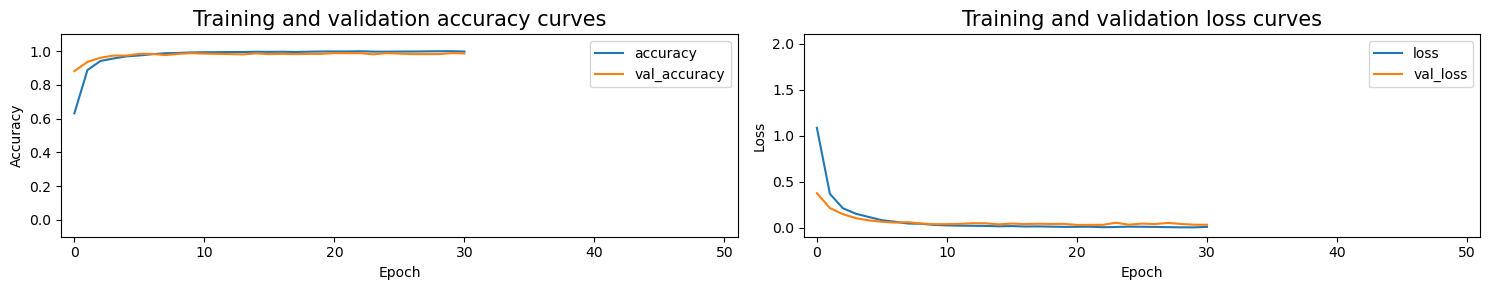

Model has run for 31 epochs

2024-06-17 21:04:53.248433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Evaluating PCA model

2024-06-17 21:04:53.709903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-17 21:04:55.083464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


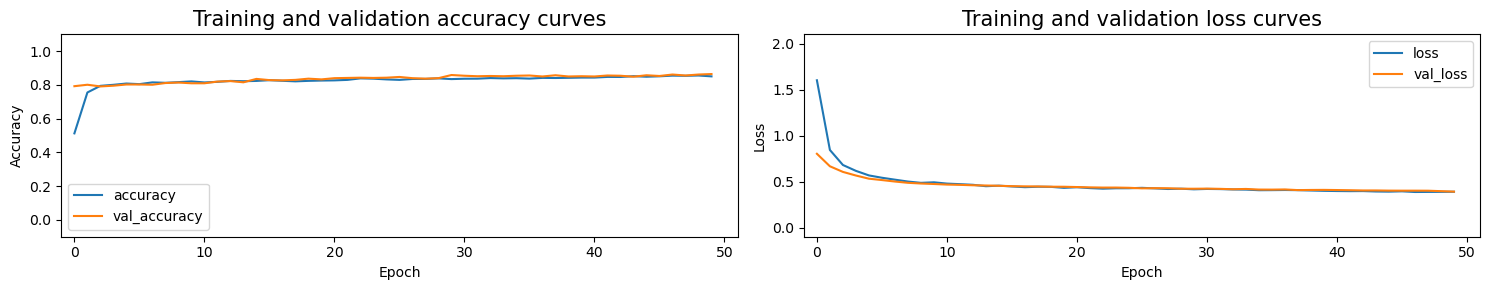

Model has run for 50 epochs

2024-06-17 21:05:50.267449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Evaluating t-SNE model

2024-06-17 21:05:50.629190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-17 21:05:52.010207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


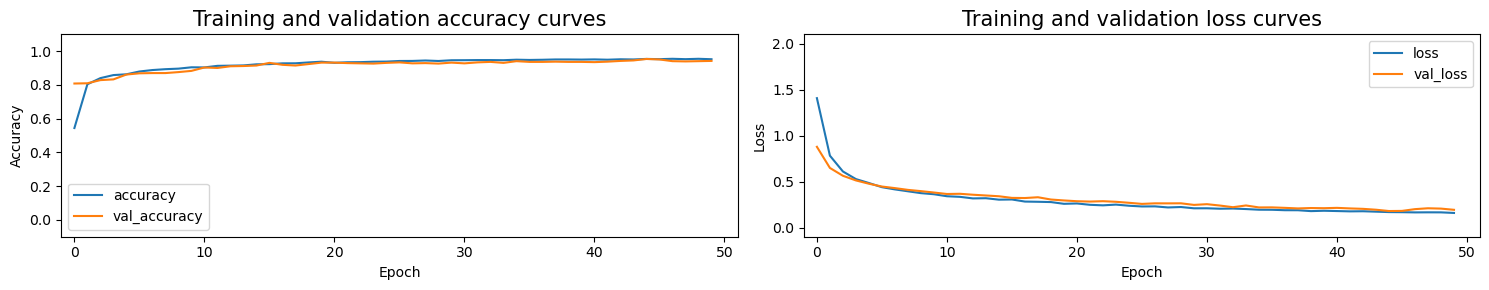

Model has run for 50 epochs

2024-06-17 21:06:45.530203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Evaluating UMAP model

2024-06-17 21:06:45.873774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-17 21:06:47.254040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


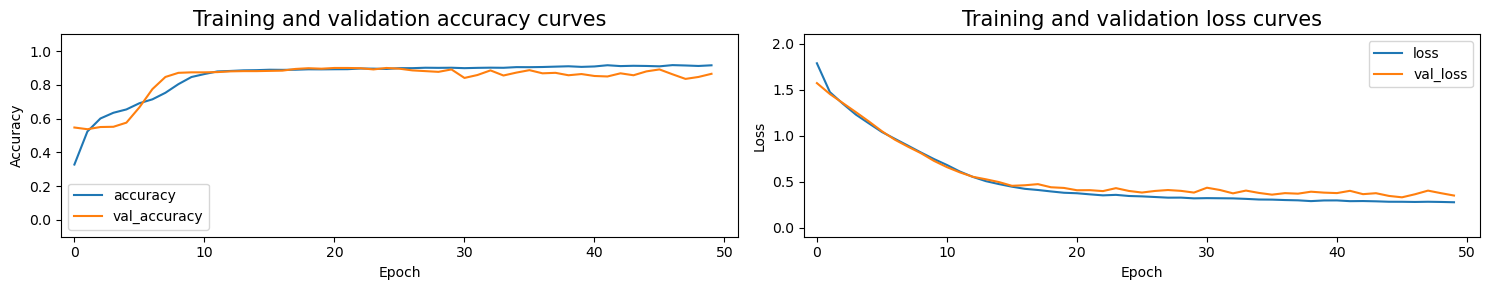

Model has run for 50 epochs

2024-06-17 21:07:41.072070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [13]:
mlp_default_results = []
mlp_default_results.append(mlp_model_default(X_train_orig, X_test_orig, y_train_orig, y_test_orig, "original"))
mlp_default_results.append(mlp_model_default(X_train_pca, X_test_pca, y_train_pca, y_test_pca, "PCA"))
mlp_default_results.append(mlp_model_default(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne, "t-SNE"))
mlp_default_results.append(mlp_model_default(X_train_umap, X_test_umap, y_train_umap, y_test_umap, "UMAP"))

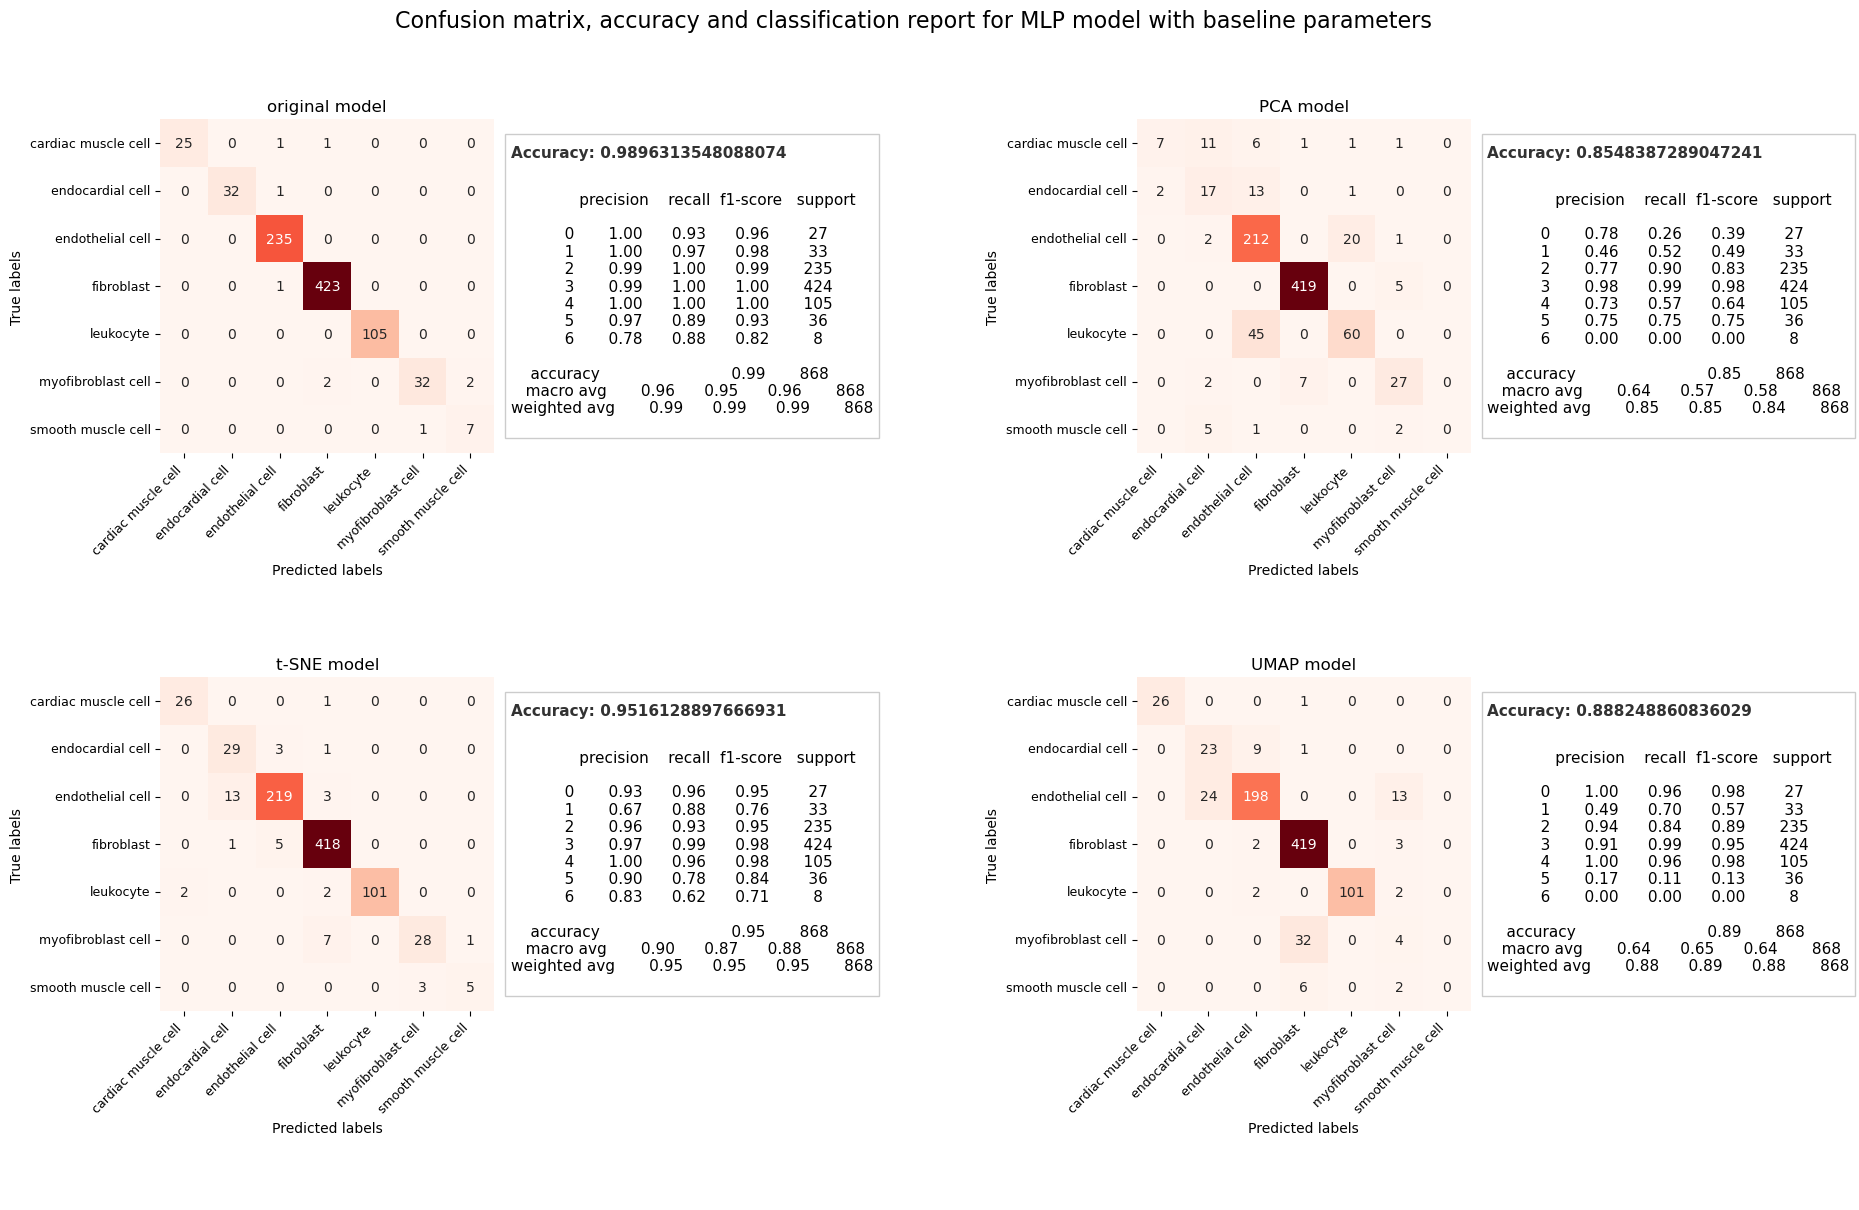

In [14]:
result_plotting(mlp_default_results, "MLP", "baseline parameters")

## Hyperparameter tuning
https://keras.io/guides/keras_tuner/getting_started/

Can we improve also these models? Yes. Like for Random Forests, MLPs come with a set of tunable parameters that can greatly change the results of the prediction. We decided again to fine-tune the model by performing a Grid Search with Cross-Validation.

We computed a new fit function (`rf_model_fit_grid`), which computed multiple models taking into consideration the following hyperparameters:

* **Number of Layers**: the number of layers that compose the neural network. This can affect
  - Importance: Significant. The depth of a neural network (number of layers) can affect its ability to learn complex patterns. Deeper networks can potentially learn more intricate features but can also lead to overfitting or gradient vanishing/exploding problems if not properly managed.
  - Guidelines: Usually determined through experimentation and balancing between model complexity and generalization.
<font color='red'> CHANGE FUNCTION NAMES!!


When considering hyperparameters for training neural networks, the importance and impact can vary depending on the specific task, dataset, and architecture. Here’s a breakdown of the hyperparameters you mentioned and their typical significance:
*
* Type of Activation Function:
  - Importance: Significant. Activation functions (e.g., ReLU, sigmoid, tanh) introduce non-linearity, which is crucial for the network to learn and approximate complex functions.
  - Guidelines: ReLU is a common choice for hidden layers; softmax for multi-class classification; sigmoid for binary classification. Selection depends on the nature of the problem and performance on validation data.
* Units (Number of Neurons):
  - Importance: Moderate. Determines the capacity of each layer to learn representations. Too few units may limit learning capacity; too many may lead to overfitting.
  - Guidelines: Often determined through experimentation and by considering the complexity of the task and the amount of data available.
* Dropout Rate:
  - Importance: Moderate to significant. Dropout helps prevent overfitting by randomly setting a fraction of input units to 0 during training, forcing the network to learn redundant representations.
  - Guidelines: Typically set between 0.2 to 0.5; however, optimal values depend on the dataset and model complexity.
* Learning Rate:
  - Importance: Critical. The learning rate controls how much to change the model in response to the estimated error each time the model weights are updated.
  - Guidelines: Tuned carefully as it affects convergence speed and model performance. Commonly ranges from 0.001 to 0.1, but optimal values can vary widely.</font>


  Explanation of the tuning code:

<font color='red'> from ChatGPT (adapt!!)

Certainly! Let's break down the build_model function and how it's configured to dynamically generate a neural network architecture using Keras Tuner (in this case, keras_tuner).

Explanation of build_model Function:
Imports and Initialization:

import keras_tuner: Importing the Keras Tuner library for hyperparameter tuning.
import tensorflow.keras.backend as K: Importing Keras backend for certain operations (such as evaluating tensors).

Function Definition:

    def build_model(hp):
      model = Sequential()

build_model function is defined with hp as the parameter, which represents HyperParameters object from Keras Tuner.

First Dense Layer:


    # Initialize units for the first layer
    units_previous = hp.Int(f"units_0", min_value=64, max_value=512, step=64)
    
    # Add the first Dense layer with fixed units from hp.Int("units_0")
    model.add(
        Dense(
            units=units_previous,
            activation=hp.Choice("activation", ["relu", "tanh"])
        )
    )
units_previous is initialized using hp.Int, defining the number of units for the first Dense layer (units_0). This is a hyperparameter to be tuned.
Dense layer is added to model with units=units_previous and activation function chosen from "relu" or "tanh" using hp.Choice.


Loop for Subsequent Layers:


    # Tune the number of layers.
    for i in range(1, hp.Int("num_layers", 1, 3)):
        # Decrease units by half from the previous layer
        units_current = K.eval(units_previous) // 2
        
        # Add Dense layer with tuned units and activation
        model.add(
            Dense(
                units=units_current,
                activation=hp.Choice("activation", ["relu", "tanh"])
            )
        )
        
        # Update units_previous for the next layer
        units_previous = units_current

        # Add Dropout layer with tuned dropout rate
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
The loop (for i in range(1, hp.Int("num_layers", 1, 3))) iterates to create multiple Dense layers.
units_current is calculated as half of units_previous, ensuring a decrease in units as you move deeper into the network.
Each Dense layer added uses hp.Choice for activation function selection and includes a Dropout layer (Dropout(rate=hp.Float(...))) with a hyperparameter to tune the dropout rate.

Output Layer and Compilation:

    model.add(Dense(7, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

Final output layer (Dense(7, activation="softmax")) with 7 units for a multiclass classification problem (adjust as per your specific problem).
Learning rate (learning_rate) defined using hp.Float for logarithmic sampling between 1e-4 to 1e-2.
Model is compiled with Adam optimizer using the defined learning rate, categorical crossentropy loss, and accuracy metric.
Return Statement:

    return model
The constructed model is returned from the function.
Usage Example:

    build_model(keras_tuner.HyperParameters())

This line demonstrates calling build_model with a HyperParameters object to configure the model architecture based on the hyperparameter choices specified.
Summary:
The build_model function dynamically constructs a neural network architecture using Keras layers and hyperparameters defined with Keras Tuner (hp). It allows for flexibility in tuning the number of layers, units per layer, activation functions, dropout rates, and learning rates, making it suitable for optimizing model performance through hyperparameter search techniques. Adjust the hyperparameter ranges (min_value, max_value, step) as per your specific requirements and experimentation goals.

In [7]:
def mlp_model_hp_tuning(X_train, X_test, y_train, y_test, dataset_name):
  '''Function that finds the best hyperparameters for a MLP neural network
  using keras_tuner and cross-validation and evaluates the model's accuracy'''

  #Name the model
  display(Markdown(f"### Evaluating {dataset_name} model"))

  #1-hot-encode the cell classes
  y_train=to_categorical(y_train)
  y_test=to_categorical(y_test)

  #Initialise the model with different hp and return best model
  model = mlp_model_init_tuner(X_train, y_train, dataset_name)
  
  #Fit, predict and evaluate the model with the test set  
  accuracy, class_report, conf_matrix = mlp_model_fit_pred(model, X_train, y_train, X_test, y_test)

  return dataset_name, accuracy, class_report, conf_matrix


def mlp_model_init_tuner(X_train, y_train, dataset_name):
  '''Initialize the model with hyperparameter tuning using Keras Tuner'''

  def build_model(hp):

    #Set seeds to 42 for reproducibility
    seed_value = 42
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
    model = Sequential()

    #Initialize units for the first layer
    units_previous = hp.Int("units_0", min_value=64, max_value=512, step=64)
    
    #Add the first Dense layer with fixed units from hp.Int("units_0")
    model.add(Dense(units_previous, input_dim=X_train.shape[1], activation=hp.Choice('activation', ['relu', 'tanh'])))

    #Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
      
      #Decrease units by half from the previous layer
      units_current = units_previous // 2

      #Add Dense layer with tuned units and activation
      model.add(Dense(units_current, activation=hp.Choice("activation", ["relu", "tanh"])))
      model.add(Dropout(rate=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step=0.1)))
      #Update units_previous for the next layer
      units_previous = units_current

    model.add(Dense(y_train.shape[1], activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

  tuner = keras_tuner.Hyperband(
      build_model,
      objective='val_accuracy',
      max_epochs=50,
      factor=3,
      directory=dataset_name,
      project_name='cell_classification'
  )

  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  #Perform the search
  tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

  #Get the optimal hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Accessing individual hyperparameters
  dropout_rate = best_hps.get('dropout_1')
  activation_function = best_hps.get('activation')
  learning_rate = best_hps.get('lr')
  num_layers = best_hps.get('num_layers')
  units_first_layer = best_hps.get('units_0')

  # Printing the best hyperparameters
  print(f"Best Hyperparameters:")
  print(f"Dropout Rate: {dropout_rate}")
  print(f"Activation Function: {activation_function}")
  print(f"Learning Rate: {learning_rate}")
  print(f"Number of Layers: {num_layers}")
  print(f"Units in First Layer: {units_first_layer}")

  # Build the best model with optimal hyperparameters
  best_model = build_model(best_hps)
  
  return best_model

### Evaluating original model

Reloading Tuner from original/cell_classification/tuner0.json
Best Hyperparameters:
Dropout Rate: 0.30000000000000004
Activation Function: relu
Learning Rate: 0.003373201432675782
Number of Layers: 1
Units in First Layer: 64


2024-06-17 20:56:43.011616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-17 20:56:44.506976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


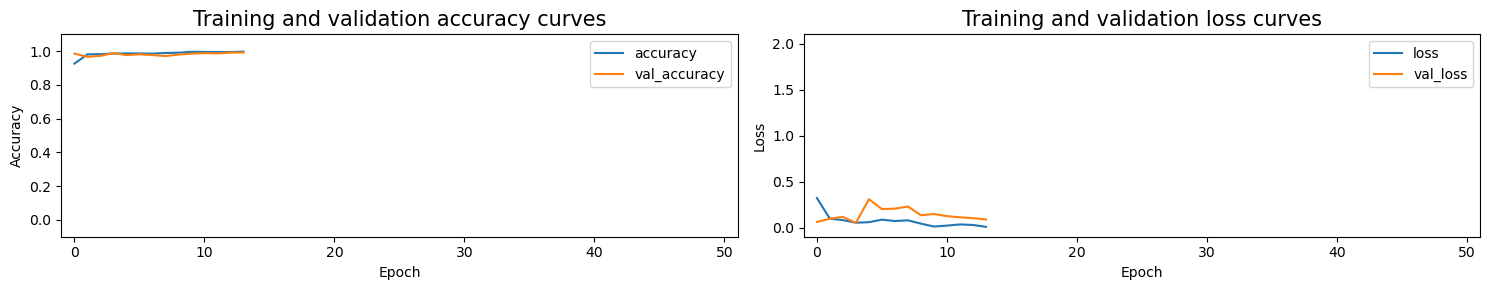

Model has run for 14 epochs

2024-06-17 20:56:59.576760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Evaluating PCA model

Reloading Tuner from PCA/cell_classification/tuner0.json
Best Hyperparameters:
Dropout Rate: 0.1
Activation Function: tanh
Learning Rate: 0.0016431536744526529
Number of Layers: 1
Units in First Layer: 256


2024-06-17 20:56:59.938824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-17 20:57:01.343236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


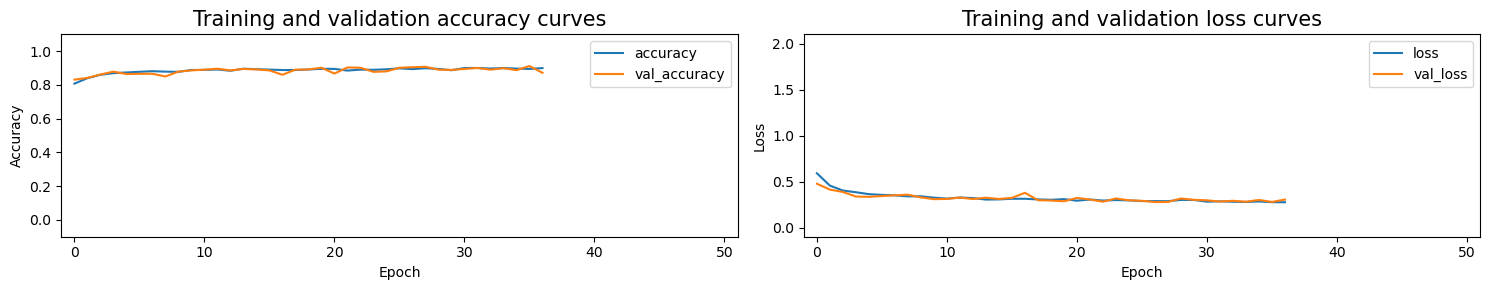

Model has run for 37 epochs

2024-06-17 20:57:41.767475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Evaluating t-SNE model

Reloading Tuner from t-SNE/cell_classification/tuner0.json
Best Hyperparameters:
Dropout Rate: 0.1
Activation Function: relu
Learning Rate: 0.006176866622548736
Number of Layers: 1
Units in First Layer: 128


2024-06-17 20:57:42.116512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-17 20:57:43.547135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


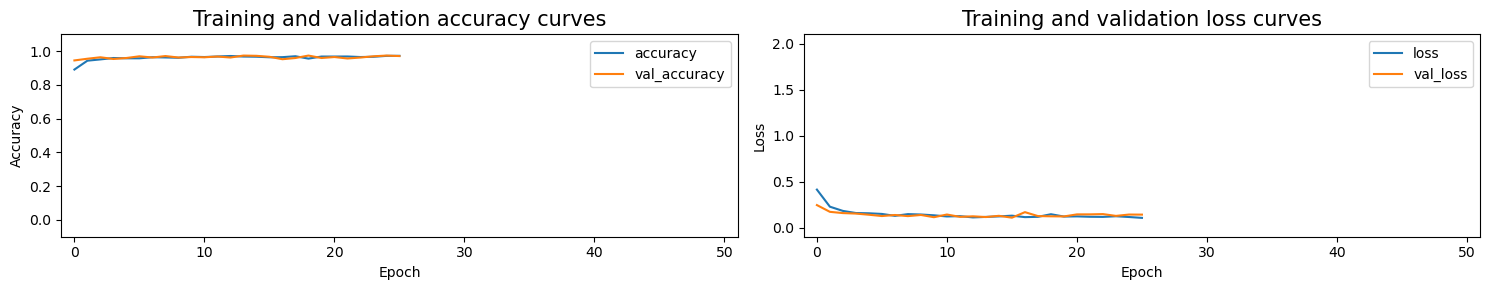

Model has run for 26 epochs

2024-06-17 20:58:11.887115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Evaluating UMAP model

Reloading Tuner from UMAP/cell_classification/tuner0.json
Best Hyperparameters:
Dropout Rate: 0.2
Activation Function: tanh
Learning Rate: 0.002166277197701016
Number of Layers: 1
Units in First Layer: 128


2024-06-17 20:58:12.233144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-17 20:58:13.418644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


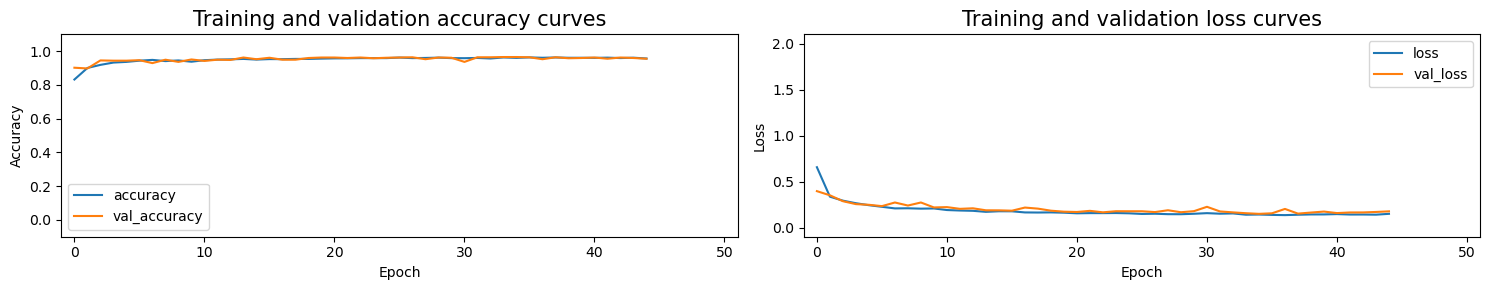

Model has run for 45 epochs

2024-06-17 20:59:00.967526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [9]:
mlp_hp_tuning_results = []
mlp_hp_tuning_results.append(mlp_model_hp_tuning(X_train_orig, X_test_orig, y_train_orig, y_test_orig, "original"))
mlp_hp_tuning_results.append(mlp_model_hp_tuning(X_train_pca, X_test_pca, y_train_pca, y_test_pca, "PCA"))
mlp_hp_tuning_results.append(mlp_model_hp_tuning(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne, "t-SNE"))
mlp_hp_tuning_results.append(mlp_model_hp_tuning(X_train_umap, X_test_umap, y_train_umap, y_test_umap, "UMAP"))

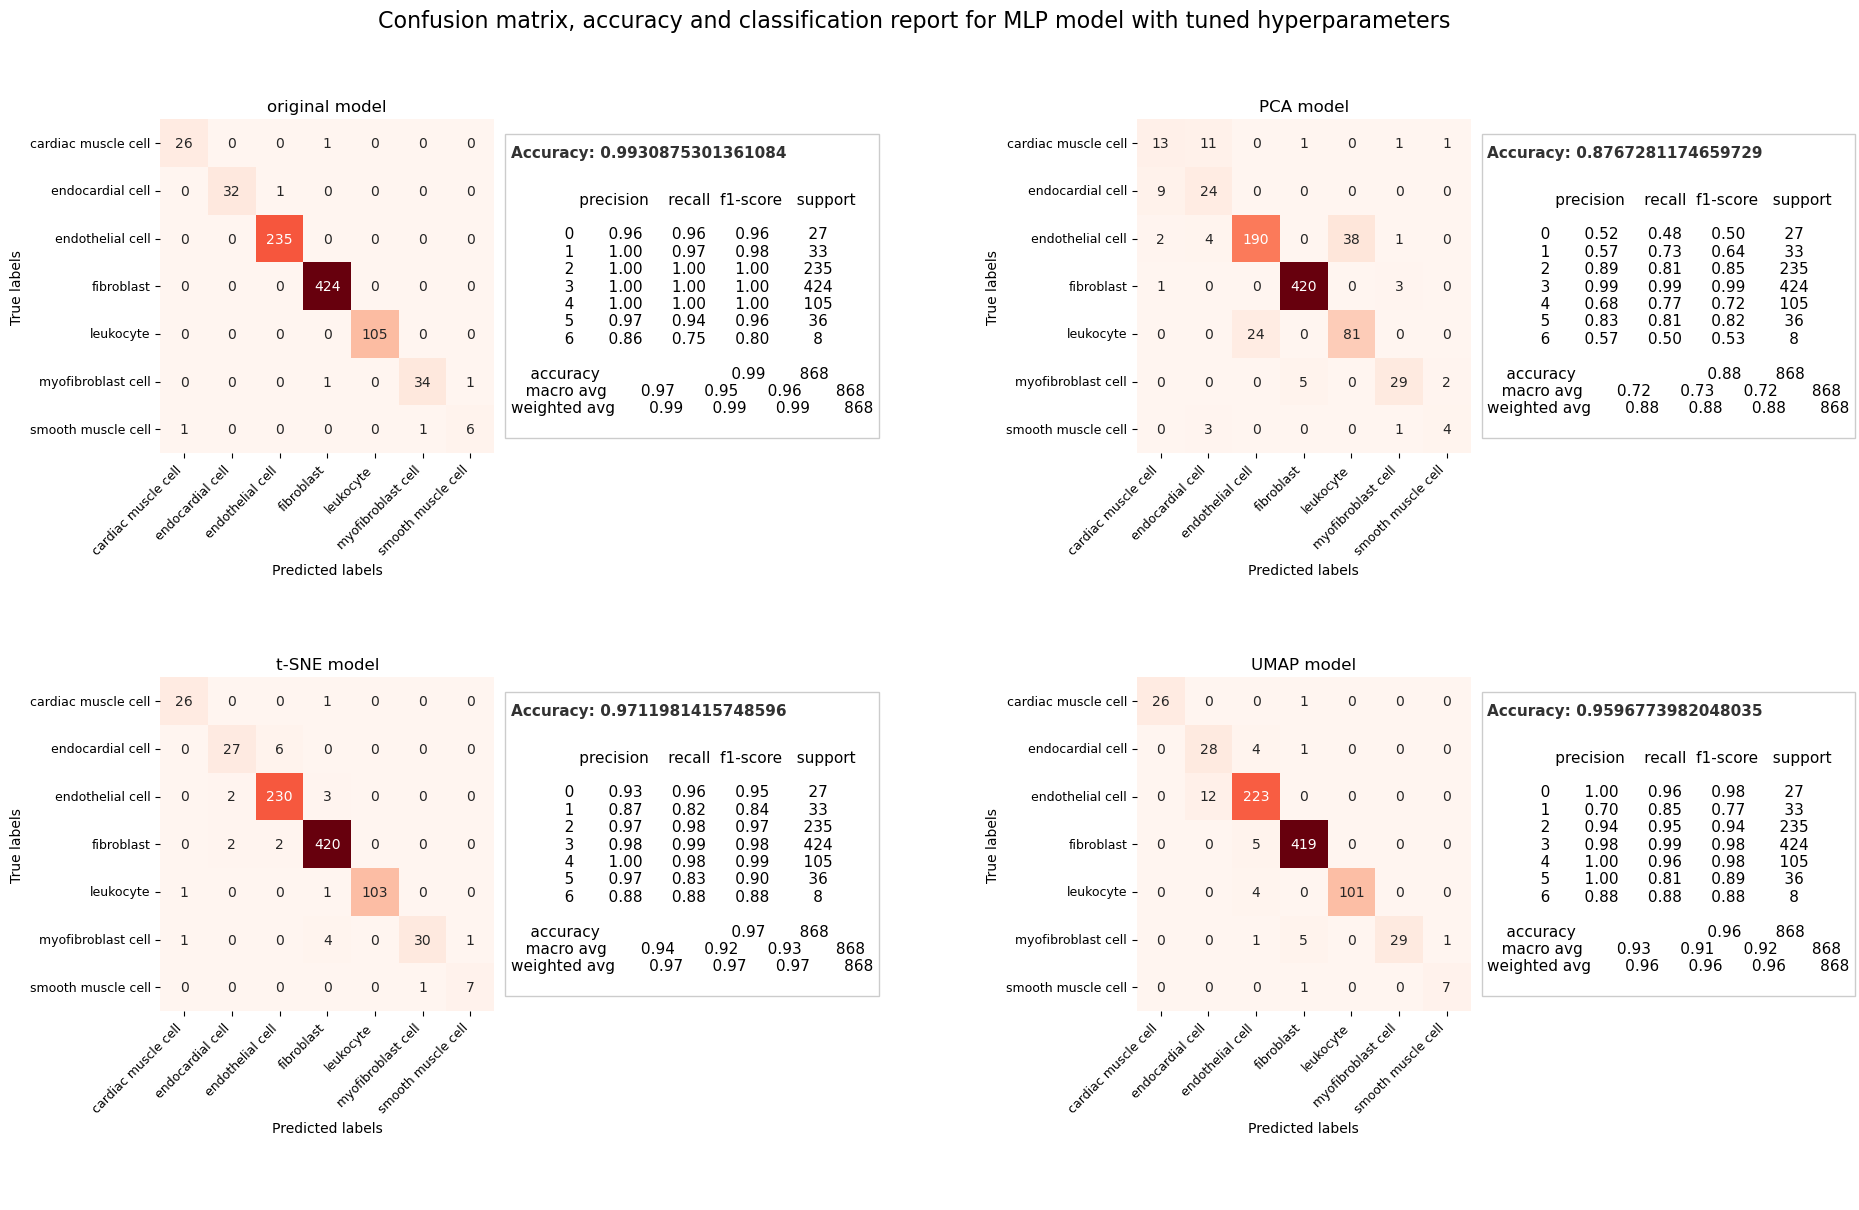

In [10]:
result_plotting(mlp_hp_tuning_results, "MLP", "tuned hyperparameters")